In [5]:
import gseapy as gp
from goatools import obo_parser
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request

# ---------------------------
# 步骤0：自动下载必要数据库文件
# ---------------------------
def download_file(url, save_path):
    """下载文件并保存到本地"""
    if not os.path.exists(save_path):
        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, save_path)
    else:
        print(f"File already exists: {save_path}")

# 下载GO本体文件（go-basic.obo）
go_obo_url = "http://geneontology.org/ontology/go-basic.obo"
go_obo_path = "go-basic.obo"
download_file(go_obo_url, go_obo_path)

# 下载Gene2Go注释文件（需NCBI FTP，此处用gseapy内置基因集替代简化）
# 注：完整Gene2Go需从NCBI下载（ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz）

# ---------------------------
# 步骤1：输入蛋白/基因列表
# ---------------------------
# 示例基因符号（替换为你的列表）
gene_symbols = ['TP53', 'APP', 'SNCA', 'IKBKG', 'MAPT', 'GSK3B', 'TREM2']

# ---------------------------
# 步骤2：KEGG通路富集（gseapy）
# ---------------------------
kegg_results = gp.enrichr(
    gene_list=gene_symbols,
    gene_sets=['KEGG_2021_Human'],
    organism='human',
    outdir=None
)
kegg_df = kegg_results.results
kegg_df['Adjusted P-value'] = -np.log10(kegg_df['Adjusted P-value'])  # 转换p值

# ---------------------------
# 步骤3：GO富集分析（GOATools）
# ---------------------------
# 加载GO本体
go = obo_parser.GODag(go_obo_path)

# 简化：使用gseapy的GO基因集代替gene2go（实际项目建议用完整NCBI注释）
go_genesets = gp.get_library_name('Human')
background_genes = list(set([gene for term in go_genesets for gene in gp.gsea.data.gmt_parser(go_genesets)]))

# 初始化GOEA
goea = GOEnrichmentStudyNS(
    background_genes,
    {ns: {gene: [] for gene in gene_symbols} for ns in ['BP']},  # 模拟关联数据
    go,
    methods=['fdr_bh'],
    alpha=0.05
)

# 运行分析（此处简化，完整版需真实基因-GO关联）
go_results = []
for gene in gene_symbols:
    go_results.extend(goea.ns2objgoea['BP'].run_study([gene]))

# 转换为DataFrame
go_df = pd.DataFrame([{
    'Term': r.name,
    'Adjusted P-value': -np.log10(r.p_fdr_bh) if r.p_fdr_bh else np.nan
} for r in go_results if hasattr(r, 'p_fdr_bh') and r.p_fdr_bh < 0.05])

# ---------------------------
# 步骤4：可视化
# ---------------------------
def plot_enrichment(df, title):
    if not df.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=df.sort_values('Adjusted P-value', ascending=False).head(10),
            y='Term',
            x='Adjusted P-value',
            palette='coolwarm'
        )
        plt.title(title)
        plt.xlabel('-log10(Adj. P-value)')
        plt.tight_layout()
        plt.show()

plot_enrichment(kegg_df, 'Top KEGG Pathways')
plot_enrichment(go_df, 'Top GO Biological Processes')

# ---------------------------
# 步骤5：保存结果
# ---------------------------
with pd.ExcelWriter('enrichment_results.xlsx') as writer:
    kegg_df.to_excel(writer, sheet_name='KEGG', index=False)
    go_df.to_excel(writer, sheet_name='GO', index=False)

print("分析完成！结果已保存到 enrichment_results.xlsx")

File already exists: go-basic.obo
go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms


AttributeError: 'function' object has no attribute 'data'

In [3]:
import gseapy as gp
from gseapy.plot import barplot, dotplot
gene_sets = 'KEGG_2016'
gene_list = ['DAB2IP', 'AKT1', 'ARNT', 'FLCN', 'XRCC6', 'BTG1', 'STAT1', 'STAT1']
# 富集
enr = gp.enrichr(gene_list=gene_list,#所需查询gene_list，可以是一个列表，也可为文件（一列，每行一个基因）
                 gene_sets=gene_sets,#gene set library，多个相关的gene set 。如所有GO term组成一个gene set library.
                 organism='Human',#持(human, mouse, yeast, fly, fish, worm)， 自定义gene_set 则无影响。
                 description='kegg',#工作运行描述
                 outdir='./data/enrichr',#输出目录
                 top_term=20,
                 cutoff=0.5#pvalue阈值
                 )
dot_png = "KEGG_2016" + "_" + "dot" + ".png"
bar_png = "KEGG_2016" + "_" + "bar" + ".png"
base_path = "./static/images/"
if os.path.exists(base_path+dot_png):
    os.remove(base_path+dot_png)
#dot
# to save your figure, make sure that ``ofname`` is not None
dotplot(enr.results.loc[enr.results["Gene_set"] == "KEGG_2016",], title='KEGG Top20 Pathway', cmap='viridis_r',
        top_term=20, legend="r",
        ofname=base_path+dot_png,
        )
#bar
if os.path.exists(base_path+bar_png):
    os.remove(base_path+bar_png)
barplot(enr.res2d, title='KEGG_2013',top_term=20,ofname=base_path+bar_png,)

TypeError: enrichr() got an unexpected keyword argument 'description'

In [7]:
import gseapy as gp
from gseapy.plot import barplot, dotplot
gene_sets = 'KEGG_2016'
gene_list = ['DAB2IP', 'AKT1', 'ARNT', 'FLCN', 'XRCC6', 'BTG1', 'STAT1', 'STAT1']
# 富集
enr = gp.enrichr(gene_list=gene_list,#所需查询gene_list，可以是一个列表，也可为文件（一列，每行一个基因）
                 gene_sets=gene_sets,#gene set library，多个相关的gene set 。如所有GO term组成一个gene set library.
                 organism='Human',#持(human, mouse, yeast, fly, fish, worm)， 自定义gene_set 则无影响。
                 description='kegg',#工作运行描述
                 outdir='./data/enrichr',#输出目录
                 top_term=20,
                 cutoff=0.5#pvalue阈值
                 )
dot_png = "KEGG_2016" + "_" + "dot" + ".png"
bar_png = "KEGG_2016" + "_" + "bar" + ".png"
base_path = "./static/images/"
if os.path.exists(base_path+dot_png):
    os.remove(base_path+dot_png)
#dot
# to save your figure, make sure that ``ofname`` is not None
dotplot(enr.results.loc[enr.results["Gene_set"] == "KEGG_2016",], title='KEGG Top20 Pathway', cmap='viridis_r',
        top_term=20, legend="r",
        ofname=base_path+dot_png,
        )
#bar
if os.path.exists(base_path+bar_png):
    os.remove(base_path+bar_png)
barplot(enr.res2d, title='KEGG_2013',top_term=20,ofname=base_path+bar_png,)

TypeError: enrichr() got an unexpected keyword argument 'description'

In [18]:
gene_list = ['DAB2IP', 'AKT1', 'ARNT', 'FLCN', 'XRCC6', 'BTG1', 'STAT1', 'STAT1']
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['GO_Biological_Process_2025'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
# GO_Biological_Process_2021                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
enr.results.head(5)

Gene_set  \
0  GO_Biological_Process_2025   
1  GO_Biological_Process_2025   
2  GO_Biological_Process_2025   
3  GO_Biological_Process_2025   
4  GO_Biological_Process_2025   

                                                Term Overlap       P-value  \
0  Regulation of Smooth Muscle Cell Proliferation...    3/54  6.461724e-07   
1            Regulation of Angiogenesis (GO:0045765)   3/211  3.927122e-05   
2       Regulation of Apoptotic Process (GO:0042981)   4/704  4.894130e-05   
3  Regulation of Cell Population Proliferation (G...   4/769  6.917097e-05   
4  Negative Regulation of Organelle Organization ...    2/44  9.863766e-05   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000235            0                     0  293.264706   
1          0.003563            0                     0   71.340144   
2          0.003563            0                     0   36.748571   
3          0.003563            0                     0   33.512854   
4          0.003563            0                     0  190.009524   

   Combined Score                    Genes  
0     4179.667100         XRCC6;STAT1;AKT1  
1      723.747089        BTG1;STAT1;DAB2IP  
2      364.725493   FLCN;STAT1;DAB2IP;AKT1  
3      321.017258  XRCC6;BTG1;STAT1;DAB2IP  
4     1752.658758                FLCN;AKT1

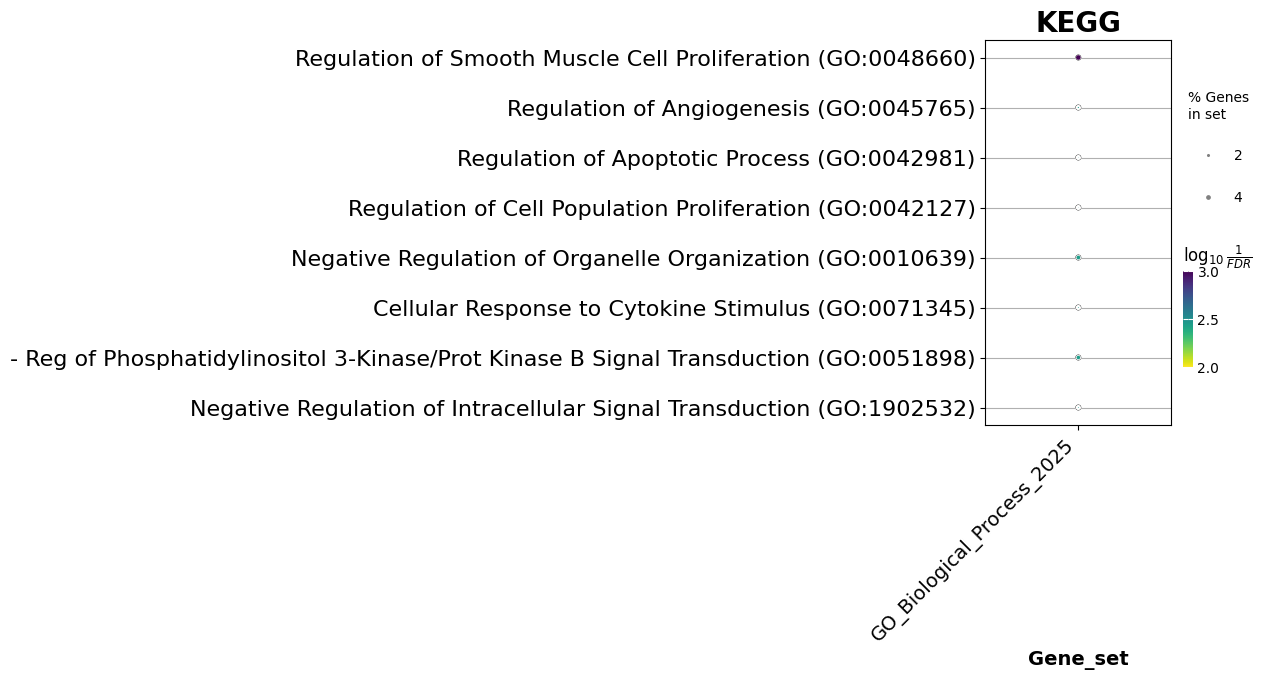

In [19]:
from gseapy import barplot, dotplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=8,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

<Axes: title={'center': 'GO_Biological_Process_2025'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

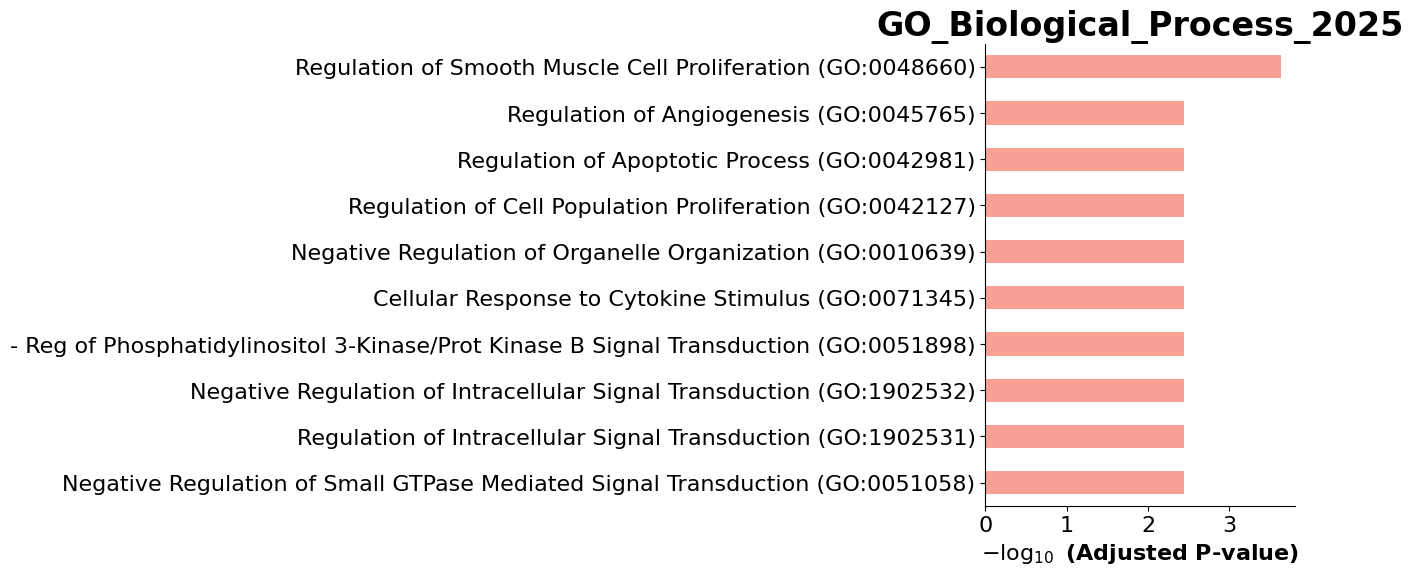

In [21]:
barplot(enr.res2d, title='GO_Biological_Process_2025',)

<Axes: title={'center': 'KEGG_2013'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

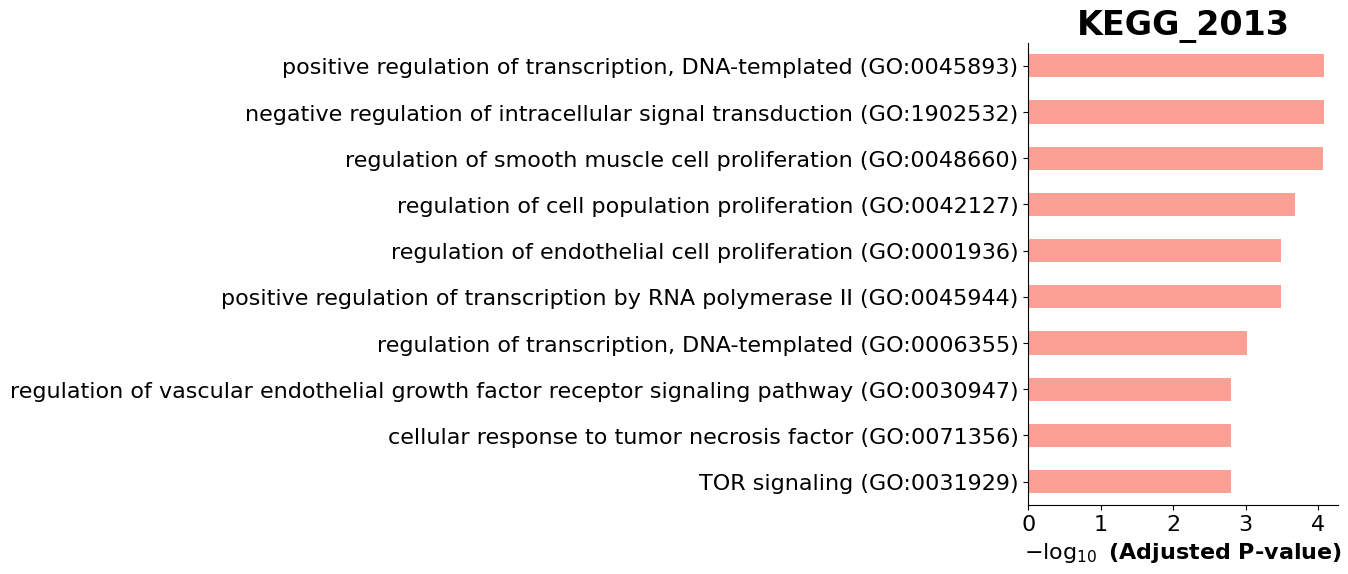

In [12]:
barplot(enr.res2d, title='KEGG_2013',)

In [22]:
enr.results.to_csv('GO_en_test.csv')

In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

In [2]:
gp.__version__

'1.1.8'

In [3]:
from gseapy import Biomart
bm = Biomart()

In [5]:
queries ={'ensembl_gene_id': ['ENSG00000125285','ENSG00000182968'] } # need to be a dict object
results = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'],
                   filters=queries)
results.tail()


ensembl_gene_id external_gene_name  entrezgene_id       go_id
37  ENSG00000182968               SOX1           6656  GO:0021884
38  ENSG00000182968               SOX1           6656  GO:0030900
39  ENSG00000182968               SOX1           6656  GO:0048713
40  ENSG00000182968               SOX1           6656  GO:1904936
41  ENSG00000182968               SOX1           6656  GO:1990830

In [6]:
results.dtypes

ensembl_gene_id       object
external_gene_name    object
entrezgene_id          Int32
go_id                 object
dtype: object

In [7]:
from gseapy import Biomart
bm = Biomart()
# note the dataset and attribute names are different
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'mmusculus_homolog_ensembl_gene',
                           'mmusculus_homolog_associated_gene_name'])

In [7]:
# with open('manything/pathway_analyse.json', 'w') as f:
#     json.dump(controls, f)
import json
with open('../manything/pathway_analyse.json', 'r') as f:
    ASD_list = json.load(f)

In [13]:
len(important_GO)

7

In [20]:
def normalize_to_zero_one(input_list):
    """
    将列表标准化到 [0, 1] 范围，如果所有值相同则返回全 0。
    
    参数:
        input_list (list): 输入的数值列表（如 -log10(p-value) 列表）
        
    返回:
        list: 标准化后的列表
    """
    if not input_list:  # 空列表直接返回
        return []
    
    min_val = min(input_list)
    max_val = max(input_list)
    
    # 如果所有值相同（max_val == min_val），返回全 0
    if max_val == min_val:
        return [0.0 for _ in input_list]
    
    # Min-Max 标准化
    normalized = [(x - min_val) / (max_val - min_val) for x in input_list]
    return normalized

In [23]:
normalize_to_zero_one(range(8))

[0.0,
 0.14285714285714285,
 0.2857142857142857,
 0.42857142857142855,
 0.5714285714285714,
 0.7142857142857143,
 0.8571428571428571,
 1.0]

In [35]:
import gseapy as gp
import math
important_GO = ['Neuron Development (GO:0048666)', 'Synapse Organization (GO:0050808)', 'Regulation of Synaptic Plasticity (GO:0048167)',
                'Axon Guidance (GO:0007411)', 'Dendrite Morphogenesis (GO:0048813)', 'Glutamate Receptor Signaling Pathway (GO:0007215)',
                'Chromatin Remodeling (GO:0006338)', 'Wnt Signaling Pathway (GO:0016055)']
result = []
for sample in ASD_list:
    sample_result = []
    use_gene = sample[0] + sample[1] + sample[3]
    print(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    if len(result) == 10:
        break

95
234
7


KeyboardInterrupt: 

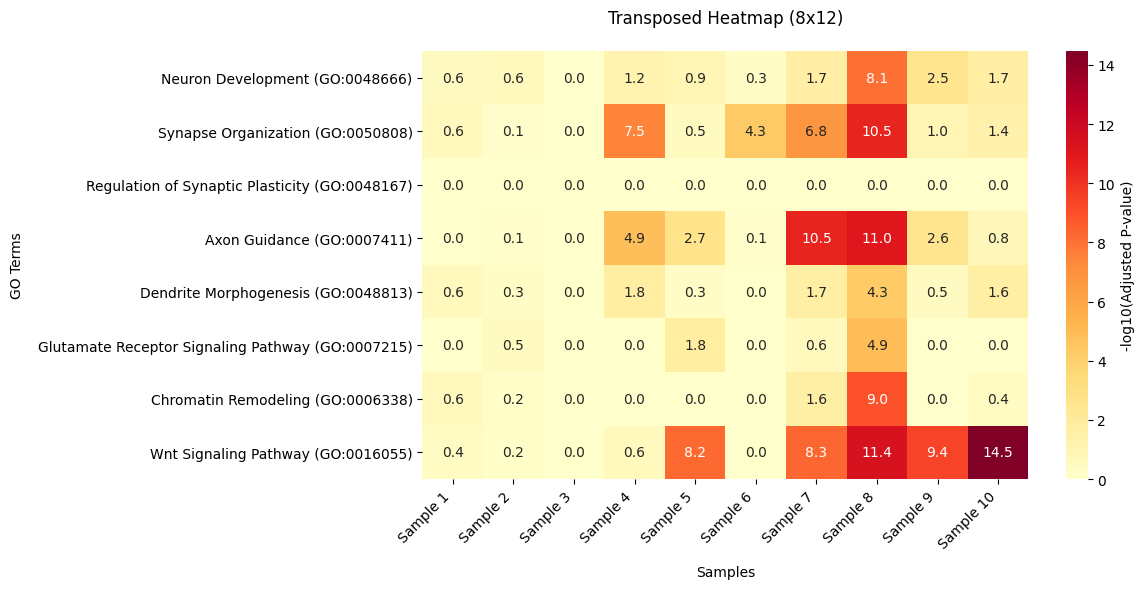

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
data = np.array(result).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"Sample {i+1}" for i in range(len(result))],
    yticklabels=[f"{important_GO[j]}" for j in range(8)],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("GO Terms", labelpad=10)

# 确保标签不被截断
plt.tight_layout()

plt.show()

<Axes: title={'center': 'GO_Biological_Process_2025'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

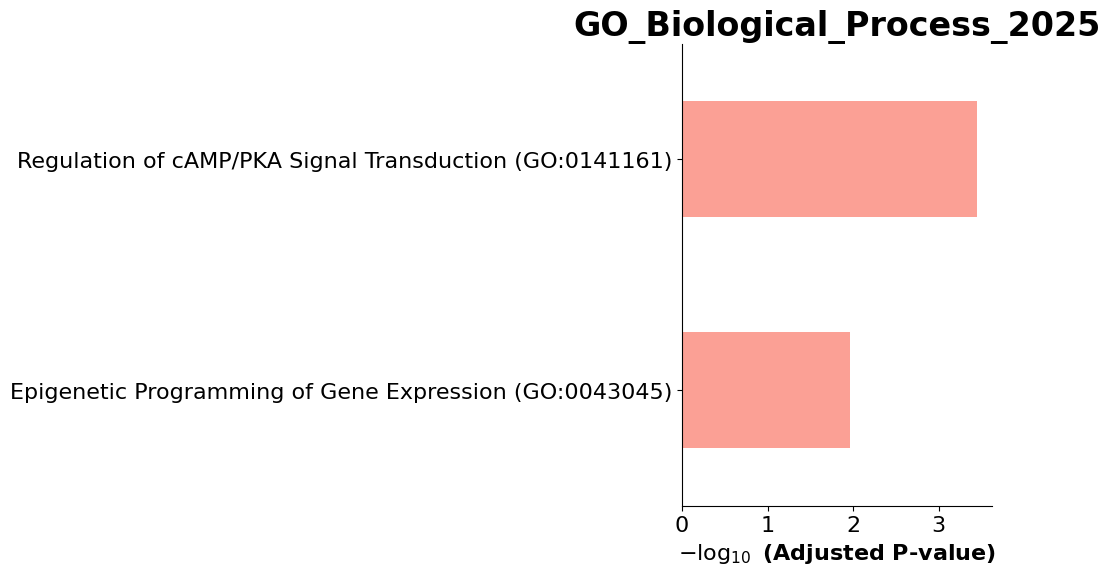

In [10]:
from gseapy import barplot, dotplot
barplot(enr.res2d, title='GO_Biological_Process_2025',)

<Axes: title={'center': 'GO_Biological_Process_2025'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

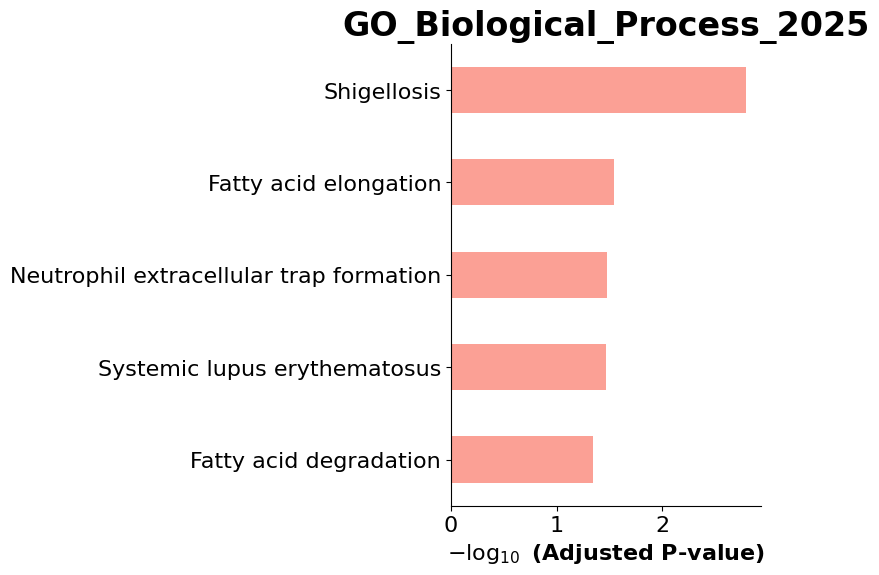

In [60]:
import gseapy as gp
import pandas as pd
sample = ASD_list[0]
use_gene = sample[0] + sample[1] + sample[3]

# Load your local GMT file
gene_sets = {}
with open("/data4/lyk/manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis
enr = gp.enrichr(gene_list=use_gene,
                 gene_sets=gene_sets,
                 organism='human',
                 outdir=None,
                 no_plot=True)
# enr.results.to_csv('GO_en_test.csv')
barplot(enr.res2d, title='GO_Biological_Process_2025',)

<Axes: title={'center': 'GO_Biological_Process_2025'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

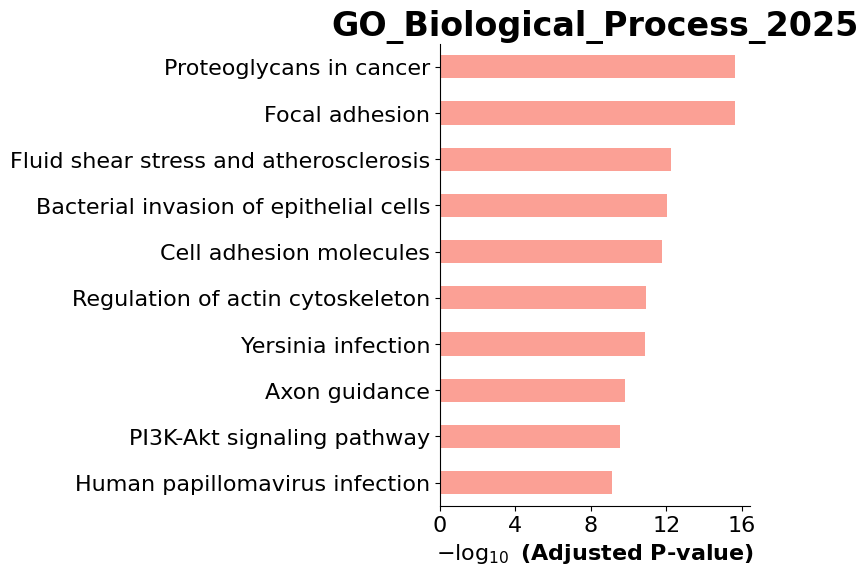

In [59]:
import gseapy as gp
import pandas as pd
sample = ASD_list[3]
use_gene = sample[0] + sample[1] + sample[3]

# Load your local GMT file
gene_sets = {}
with open("/data4/lyk/manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis
enr = gp.enrichr(gene_list=use_gene,
                 gene_sets=gene_sets,
                 organism='human',
                 outdir=None,
                 no_plot=True)
# enr.results.to_csv('GO_en_test.csv')
barplot(enr.res2d, title='GO_Biological_Process_2025',)

7


<Axes: title={'center': 'GO_Biological_Process_2025'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

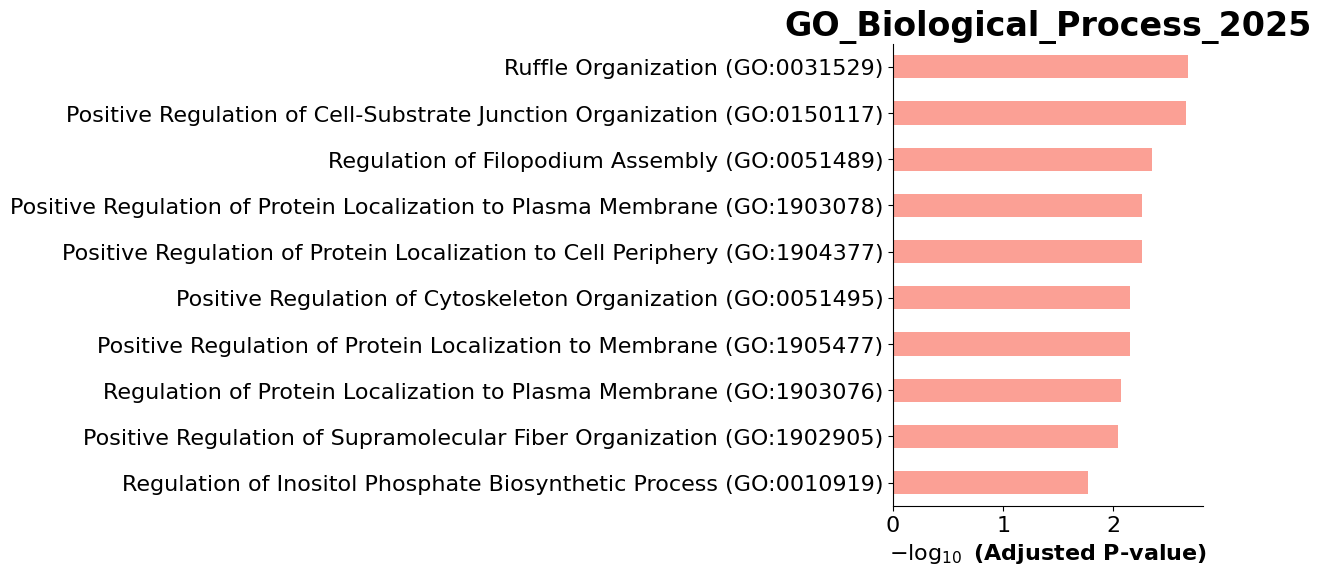

In [16]:
import gseapy as gp
sample = ASD_list[2]
use_gene = sample[0] + sample[1] + sample[3]
print(len(use_gene))
enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
             gene_sets=['GO_Biological_Process_2025'],
             organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None, # don't write to disk
            )
enr.results.to_csv('GO_en_test.csv')
barplot(enr.res2d, title='GO_Biological_Process_2025',)

332
(2487, 10)


<Axes: title={'center': 'GO_Biological_Process_2025'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

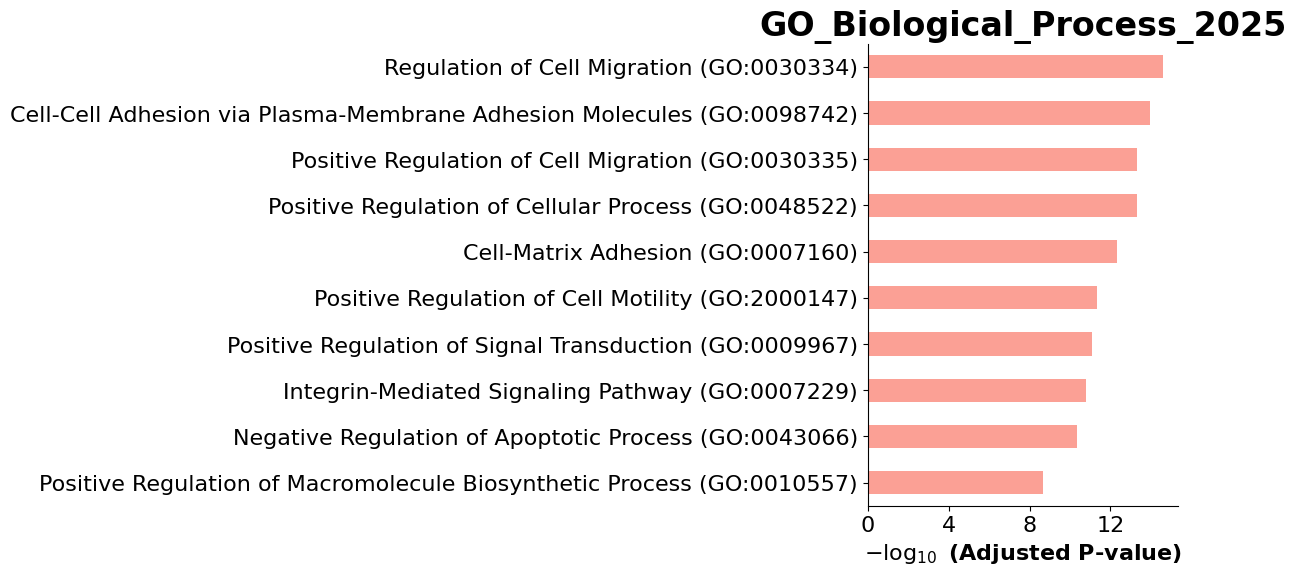

In [23]:
import gseapy as gp
sample = ASD_list[3]
use_gene = sample[0] + sample[1] + sample[3]
print(len(use_gene))
enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
             gene_sets=['GO_Biological_Process_2025'],
             organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None, # don't write to disk
            )
enr.results.to_csv('GO_en_test.csv')
print(enr.results.shape)
barplot(enr.res2d, title='GO_Biological_Process_2025',)

327
(2319, 10)


<Axes: title={'center': 'GO_Biological_Process_2025'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

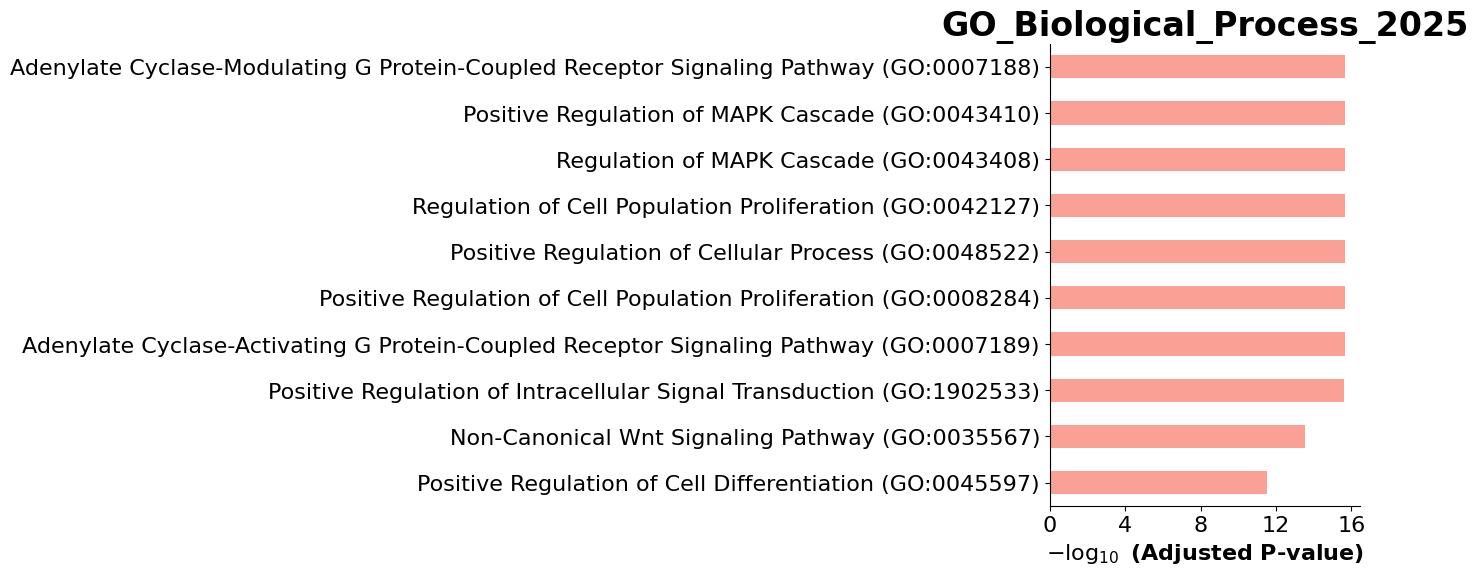

In [22]:
import gseapy as gp
sample = ASD_list[4]
use_gene = sample[0] + sample[1] + sample[3]
print(len(use_gene))
enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
             gene_sets=['GO_Biological_Process_2025'],
             organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None, # don't write to disk
            )
enr.results.to_csv('GO_en_test.csv')
print(enr.results.shape)
barplot(enr.res2d, title='GO_Biological_Process_2025',)

In [21]:
with open('../manything/biology_process_list.json', 'w') as f:
    json.dump(enr.results['Term'].to_list(), f)

In [ ]:
import json
import re
file_path = '../manything/KEGG_2021_Human.txt'
pathway_names = []

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        # 按制表符分割行，取第一个非空列作为通路名称
        parts = line.strip().split('\t')
        pathway_name = parts[0].strip()  # 第一列为通路名称
        if pathway_name:  # 确保非空
            pathway_names.append(pathway_name)

# 输出所有通路名称
print("提取的通路名称列表:")
for name in pathway_names:
    print(name)

# 可选：保存到JSON文件
import json
with open('pathway_names.json', 'w', encoding='utf-8') as f:
    json.dump(pathway_names, f, indent=4)
print("\n通路名称已保存到 pathway_names.json")

In [65]:
import gseapy as gp
import math
gene_sets = {}
with open("/data4/lyk/manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

important_GO = [
    "Amino acid metabolism",
    "Neuroactive ligand-receptor interaction",
    "Cytokine-cytokine receptor interaction",
    "Calcium signaling pathway",
    "Synaptic vesicle cycle"
]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []
for sample in ASD_list:
    sample_result = []
    use_gene = sample[0] + sample[1] + sample[3]
    # print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    # if len(result) == 30:
    #     break
# Calculate the average for each GO term in ssss
average_scores = {go: (sum(scores) / len(scores) if scores else 0) for go, scores in ssss.items()}

# Find the top 5 GO terms with the highest average scores
top_5_go = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:8]

# Print the results
for go_term, avg_score in top_5_go:
    print("GO term:", go_term, "Average score:", avg_score)

GO term: Pathways in cancer Average score: 6.770889958584416
GO term: Proteoglycans in cancer Average score: 6.48785160357456
GO term: MAPK signaling pathway Average score: 5.007877968771244
GO term: Hepatitis B Average score: 4.389942593749428
GO term: PI3K-Akt signaling pathway Average score: 4.348567655256067
GO term: Focal adhesion Average score: 3.878373799163439
GO term: Lipid and atherosclerosis Average score: 3.8577982796388173
GO term: Shigellosis Average score: 3.834911050964086


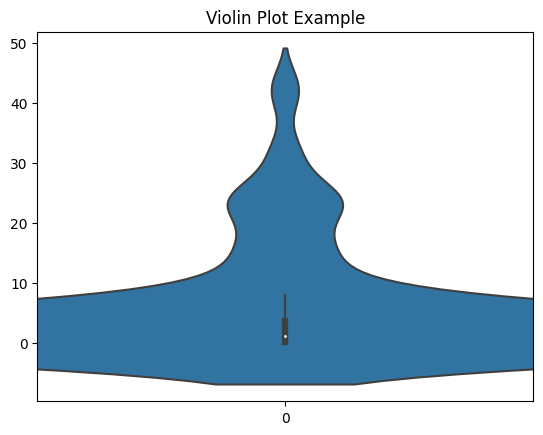

In [85]:
sns.violinplot(data=ssss['Hepatitis B'], width=3)

# 添加标题
plt.title("Violin Plot Example")

# 显示图形
plt.show()

In [1]:
import pandas as pd

# 读取 Excel 文件中的所有表格 manything/protein_net/41588_2018_130_MOESM3_ESM.xlsx
# file_path = '../manything/protein_net/CDH_gene.xlsx'
file_path = '../manything/protein_net/41588_2018_130_MOESM6_ESM.xlsx'
sheets = pd.read_excel(file_path, sheet_name=None, header=None)

# 将每个表格存储到单独的 DataFrame
dataframes = {sheet_name: df for sheet_name, df in sheets.items()}
importants = []
# 打印每个 DataFrame 的名称和前几行
for name, df in dataframes.items():
    print(f"表格名称: {name}")
    # print(len(set(df[0].tolist()) & set(pros['preferred_name'].tolist())), len(df[0].tolist()))  # 打印前几行
    importants.append(df[0].tolist())
len(importants), len(importants[0])


表格名称: FMRP
表格名称: CHM
表格名称: EMB
表格名称: PSD
表格名称: SFARI
表格名称: SFARIhq
表格名称: DN65


(7, 794)

In [2]:
import gseapy as gp
import math
gene_sets = {}
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

important_GO = [
    "Amino acid metabolism",
    "Neuroactive ligand-receptor interaction",
    "Cytokine-cytokine receptor interaction",
    "Calcium signaling pathway",
    "Synaptic vesicle cycle"
]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []
for use_gene in importants:
    sample_result = []
    # use_gene = sample[0] + sample[1] + sample[3]
    # print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    # if len(result) == 30:
    #     break
# Calculate the average for each GO term in ssss
average_scores = {go: (sum(scores) / len(scores) if scores else 0) for go, scores in ssss.items()}

# Find the top 5 GO terms with the highest average scores
top_5_go = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:15]

# Print the results
important_GO = []
for go_term, avg_score in top_5_go:
    print("GO term:", go_term, "Average score:", avg_score)
    important_GO.append(go_term)

GO term: Glutamatergic synapse Average score: 4.901705667886797
GO term: Pathways of neurodegeneration Average score: 4.492264069860361
GO term: Thyroid hormone signaling pathway Average score: 4.488016641884726
GO term: Long-term potentiation Average score: 4.2635691423683
GO term: Dopaminergic synapse Average score: 4.181322702272012
GO term: Synaptic vesicle cycle Average score: 3.916260957500159
GO term: Circadian entrainment Average score: 3.7686238120600453
GO term: Lysine degradation Average score: 3.766527903622444
GO term: Endocytosis Average score: 3.736852971214156
GO term: Endocrine and other factor-regulated calcium reabsorption Average score: 3.582698788510778
GO term: Salmonella infection Average score: 3.3844650343255482
GO term: Adrenergic signaling in cardiomyocytes Average score: 3.249040348446448
GO term: Cell cycle Average score: 3.128482607478704
GO term: Retrograde endocannabinoid signaling Average score: 3.085597559447178
GO term: Huntington disease Average scor

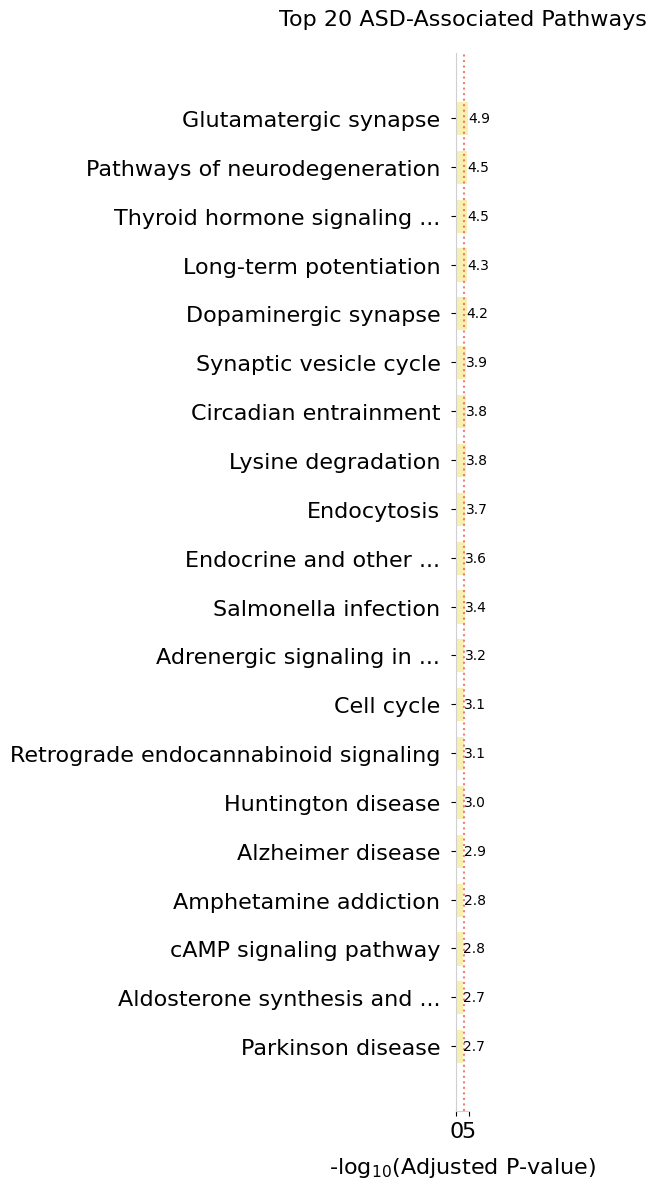

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data_hot = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:20]
labels, values = zip(*data_hot)
plt.figure(figsize=(5, 12))
ax = plt.gca()
def truncate_label(label, max_words=3):
    words = label.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words]) + ' ...'
    return label
# Custom colors
frontsize = 16
main_color = '#F8F0B0'  # Your requested navy blue
highlight_color = '#4c8cbd'  # Lighter complementary blue

# Create horizontal bars with improved formatting
bars = ax.barh([truncate_label(e) for e in labels], values, 
               color=main_color,
               height=0.7,  # Slightly thicker bars
               edgecolor='white',
               linewidth=0.7)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1,  # x-position (right of bar)
            bar.get_y() + bar.get_height()/2,  # y-position (center of bar)
            f'{width:.1f}',  # Formatted value
            va='center',
            ha='left',
            fontsize=10)

# Styling improvements
ax.set_xlabel('-log$_{10}$(Adjusted P-value)', 
              fontsize = frontsize, labelpad=10)
ax.set_title('Top 20 ASD-Associated Pathways', 
             fontsize = frontsize, pad=20)

# Adjust spines (borders) for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#d0d0d0')
ax.spines['bottom'].set_color('#d0d0d0')

# Grid and tick formatting
ax.xaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)  # Grid behind bars

# Improved y-axis labels (choose either OPTION 1 or 2 below)

# OPTION 1: Larger font + black (recommended)
ax.tick_params(axis='y', which='major', 
               labelsize=frontsize,  # Increased from default 10
               colors='black',  # Pure black
               pad=8)

# OPTION 2: Bold font + black (alternative)
# ax.tick_params(axis='y', which='major',
#                colors='black',
#                labelsize=11,
#                pad=8)
# for label in ax.get_yticklabels():
#     label.set_fontweight('bold')

ax.tick_params(axis='x', labelsize=frontsize)  # Keep x-axis ticks gray

# Add threshold line
threshold = 3
ax.axvline(x=threshold, color='#e74c3c', linestyle=':', alpha=0.7, linewidth=1.5)

# Invert y-axis to show highest value at top
ax.invert_yaxis()

plt.savefig('../manything/ASD_pvalue.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [1]:
import networkx as nx
G = nx.read_gml('../manything/graph_ppi_only_p.gml')

In [4]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
# samples = pd.read_csv('../manything/ASD_use.csv')
# samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
# samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []
number2 = []
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []

nnnn = 30
import json
with open('../manything/disease_onlyp_ASD3.json', 'r') as f:
    CDH_list = json.load(f)

# for index, sample in enumerate(CDH_list):
#     use_gene = list(G.neighbors(sample['mutation']))
#     # if any(item not in sample['nab'][0]+sample['nab'][1]+sample['nab'][2]+sample['nab'][3] for item in use_gene):
#     #     print('err0')
#     #     break

#     for class_index in range(len(sample['nab'])):
#         CDH_list[index]['nab'][class_index] = [gene for gene in CDH_list[index]['nab'][class_index] if gene in use_gene]

for idx, sample in enumerate(CDH_list):
    if len(buer) == nnnn + 1:
        break
    sample_result = []
    samplep = sample['nab']
    use_gene = samplep[0] + samplep[1] + samplep[3]# + [samples.iloc[idx]['Gene.refGene']]
    # print(len(use_gene))
    geneuse = sample['mutation']
    number.append(len(use_gene))
    number2.append(len(samplep[0] + samplep[1] + samplep[2] + samplep[3]))
    if len(use_gene) == 0:
        result.append([0 for _ in range(len(important_GO))])

        sample_buer = []
        # print(len(use_gene))
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)
        
        continue
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    if len(pandas_use) == 0:
        print(idx)
        result.append([0 for _ in range(len(important_GO))])
        sample_buer = []
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)



        
        continue
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            
            sample_result.append(-math.log10(p_value))

            # p_value = item['Overlap'].values[0]  # 提取 P-value
            
            # sample_result.append(int(p_value.split('/')[0]))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)


    sample_buer = []
    # print(len(use_gene))
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

2025-04-29 07:03:03,503 [ERROR] No hits returned for all input gene sets!


3
PLCD4 Thyroid hormone signaling pathway 3
KMT2A Lysine degradation 18
TUBA1A Pathways of neurodegeneration 21
TUBA1A Salmonella infection 21
TUBA1A Huntington disease 21


2025-04-29 07:03:09,581 [ERROR] No hits returned for all input gene sets!


27
POLR2A Huntington disease 28
PER1 Circadian entrainment 29


In [10]:
samplep = CDH_list[0]['nab']
len(samplep[0] + samplep[1] + samplep[3]), len(samplep[0] + samplep[1] + samplep[2] + samplep[3])

(4, 132)

In [5]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
samples = pd.read_csv('../manything/ASD_use.csv')
samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []

nnnn = 30
import json
with open('../manything/pathway_analyse1.json', 'r') as f:
    ASD_list = json.load(f)


for idx, sample in enumerate(ASD_list):
    sample_result = []
    use_gene = sample[0] + sample[1] + sample[3]# + [samples.iloc[idx]['Gene.refGene']]
    # print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    if len(result) == nnnn:
        break
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []
for idx, sample in enumerate(ASD_list):
    sample_buer = []
    # print(len(use_gene))
    pandas_use = enr.results
    geneuse = samples.iloc[idx]['Gene.refGene']
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)

        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

/tmp/ipykernel_3916450/821504416.py:5: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('../manything/ASD_use.csv')


In [3]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
# samples = pd.read_csv('../manything/ASD_use.csv')
# samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
# samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []

ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []

nnnn = 30
import json
with open('../manything/disease_onlyp_ASD.json', 'r') as f:
    CDH_list = json.load(f)

# for index, sample in enumerate(CDH_list):
#     use_gene = list(G.neighbors(sample['mutation']))
#     # if any(item not in sample['nab'][0]+sample['nab'][1]+sample['nab'][2]+sample['nab'][3] for item in use_gene):
#     #     print('err0')
#     #     break

#     for class_index in range(len(sample['nab'])):
#         CDH_list[index]['nab'][class_index] = [gene for gene in CDH_list[index]['nab'][class_index] if gene in use_gene]

for idx, sample in enumerate(CDH_list):
    sample_result = []
    samplep = sample['nab']
    use_gene = samplep[0] + samplep[1] + samplep[3]# + [samples.iloc[idx]['Gene.refGene']]
    # print(len(use_gene))
    geneuse = sample['mutation']
    number.append(len(use_gene))
    if len(use_gene) == 0:
        result.append([0 for _ in range(len(important_GO))])

        sample_buer = []
        # print(len(use_gene))
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)
        
        continue
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    if len(pandas_use) == 0:
        print(idx)
        result.append([0 for _ in range(len(important_GO))])
        sample_buer = []
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)



        
        continue
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            
            sample_result.append(-math.log10(p_value))

            # p_value = item['Overlap'].values[0]  # 提取 P-value
            
            # sample_result.append(int(p_value.split('/')[0]))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)


    sample_buer = []
    # print(len(use_gene))
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

2025-04-12 07:57:17,352 [ERROR] No hits returned for all input gene sets!


3
PLCD4 Thyroid hormone signaling pathway 3
KMT2A Lysine degradation 18
TUBA1A Pathways of neurodegeneration 21


2025-04-12 07:57:22,989 [ERROR] No hits returned for all input gene sets!


27
PER1 Circadian entrainment 29


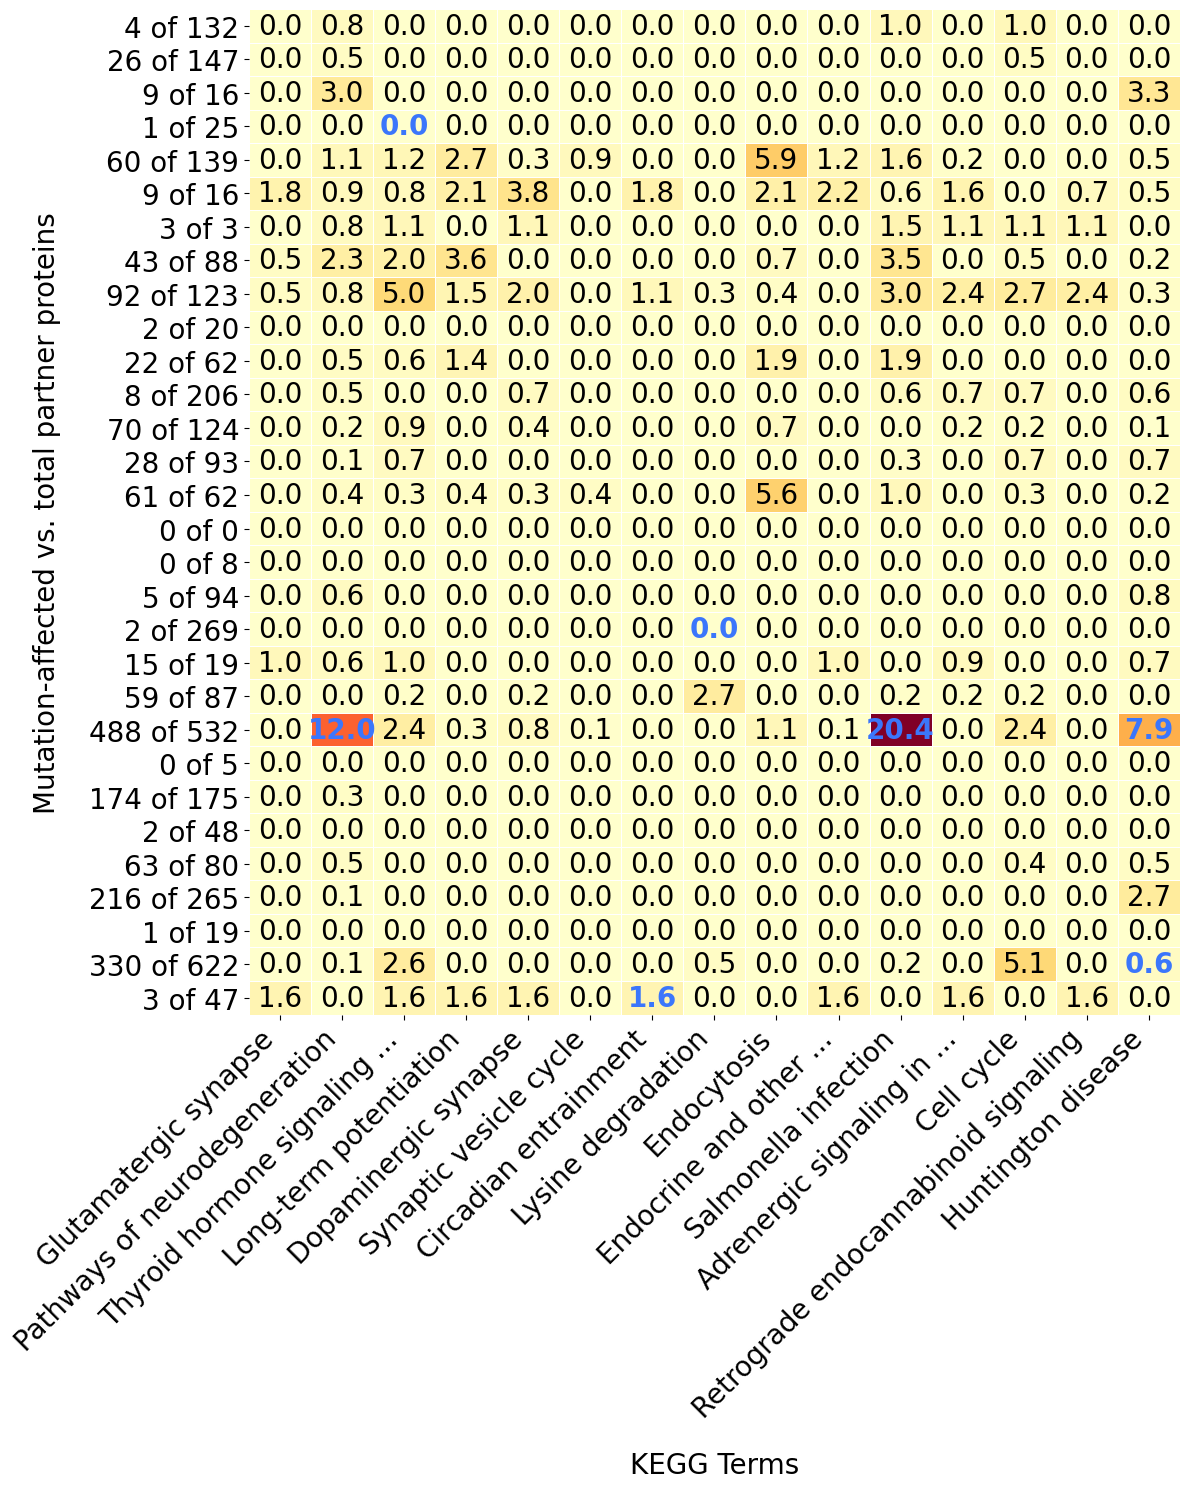

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume result is your data matrix (rows=samples, cols=GO/KEGG Terms)
start = 0
data = np.array(result[start:])  # Transposed data (rows=Terms, cols=samples)

def truncate_label(label, max_words=3):
    words = label.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words]) + ' ...'
    return label


# --- Dynamic height calculation ---
base_height = 6  
term_height = 0.3  
dynamic_height = base_height + term_height * data.shape[0]  
fontsize = 20  # Unified font size for all elements

# Create figure with dynamic height
plt.figure(figsize=(12, dynamic_height))

# Draw heatmap with font control
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd',
    cbar=False,
    annot_kws={"size": fontsize, "color": "black"},  # Control annotation font
    yticklabels=[f"{number[i]} of {number2[i]}" for i in range(len(result[start:]))],
    xticklabels=[truncate_label(label) for label in important_GO[start:]],
    linewidths=0.5
)

# Adjust axis labels
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=fontsize  # X-tick labels
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=fontsize,  # Y-tick labels
    rotation=0
)

# Set axis titles
ax.set_xlabel(
    "KEGG Terms", 
    labelpad=fontsize, 
    fontsize=fontsize  # X-axis title
)
ax.set_ylabel(
    "Mutation-affected vs. total partner proteins", 
    labelpad=fontsize, 
    fontsize=fontsize  # Y-axis title
)

# Highlight specific cells
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:
        text.set_color('#3b76fb')
        text.set_weight('bold')
        text.set_size(fontsize)  # Ensure highlighted text matches size

# Add colorbar with matching font
cbar = ax.figure.colorbar(ax.collections[0])
cbar.ax.tick_params(labelsize=fontsize)  # Colorbar tick labels

ax.collections[0].colorbar.remove() 

plt.savefig('../manything/ASD_hotplot.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [55]:
pandas_use.head()

Gene_set                                    Term Overlap   P-value  \
0  gs_ind_0  Adrenergic signaling in cardiomyocytes   1/150  0.018569   
1  gs_ind_0                              Alcoholism   1/186  0.023026   
2  gs_ind_0     Aldosterone synthesis and secretion    1/98  0.012132   
3  gs_ind_0                              Amoebiasis   1/102  0.012627   
4  gs_ind_0                   Amphetamine addiction    1/69  0.008542   

   Adjusted P-value  Odds Ratio  Combined Score   Genes  
0          0.026628  159.100334      634.215984  PRKACB  
1          0.030110  127.641509      481.355651  PRKACB  
2          0.025628  245.553846     1083.366900  PRKACB  
3          0.025628  235.758621     1030.719428  PRKACB  
4          0.025628  350.781022     1670.697428  PRKACB

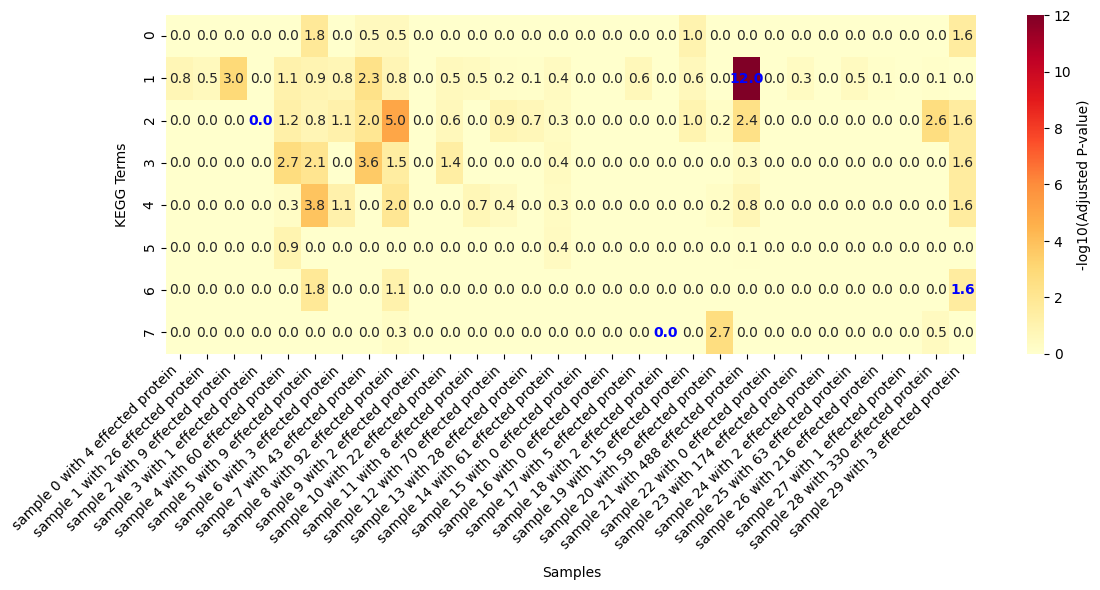

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"sample {i} with {str(number[i])} effected protein" for i in range(len(result[start:]))], # str(number[i])
    yticklabels=[f"{j}" for j in range(len(important_GO))],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()

In [7]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
# samples = pd.read_csv('../manything/ASD_use.csv')
# samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
# samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []

ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []

nnnn = 300
import json
with open('../manything/disease_oldPPI_CDH.json', 'r') as f:
    CDH_list = json.load(f)


for idx, sample in enumerate(CDH_list):
    sample_result = []
    samplep = sample['nab']
    use_gene = samplep[0] + samplep[1] + samplep[3]# + [samples.iloc[idx]['Gene.refGene']]
    # print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)


    sample_buer = []
    # print(len(use_gene))
    pandas_use = enr.results
    geneuse = sample['mutation']
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

In [94]:
sample_index = 25
GO_index = 1
use = CDH_list[sample_index]['nab']
effected = use[0]+use[1]+use[3]
print(set(use[0])&set(gene_sets[important_GO[GO_index]]), set(use[1]) & set(gene_sets[important_GO[GO_index]]), set(use[3]) & set(gene_sets[important_GO[GO_index]]))
for iiia in set(effected) & set(gene_sets[important_GO[GO_index]]):
    print(iiia)
print(CDH_list[sample_index]['mutation'])
set(effected) & set(gene_sets[important_GO[GO_index]]), CDH_list[sample_index]['mutation'], important_GO[GO_index]


{'SOD1', 'OPTN'} {'AMBRA1'} set()
AMBRA1
SOD1
OPTN
DCAF4


({'AMBRA1', 'OPTN', 'SOD1'}, 'DCAF4', 'Pathways of neurodegeneration')

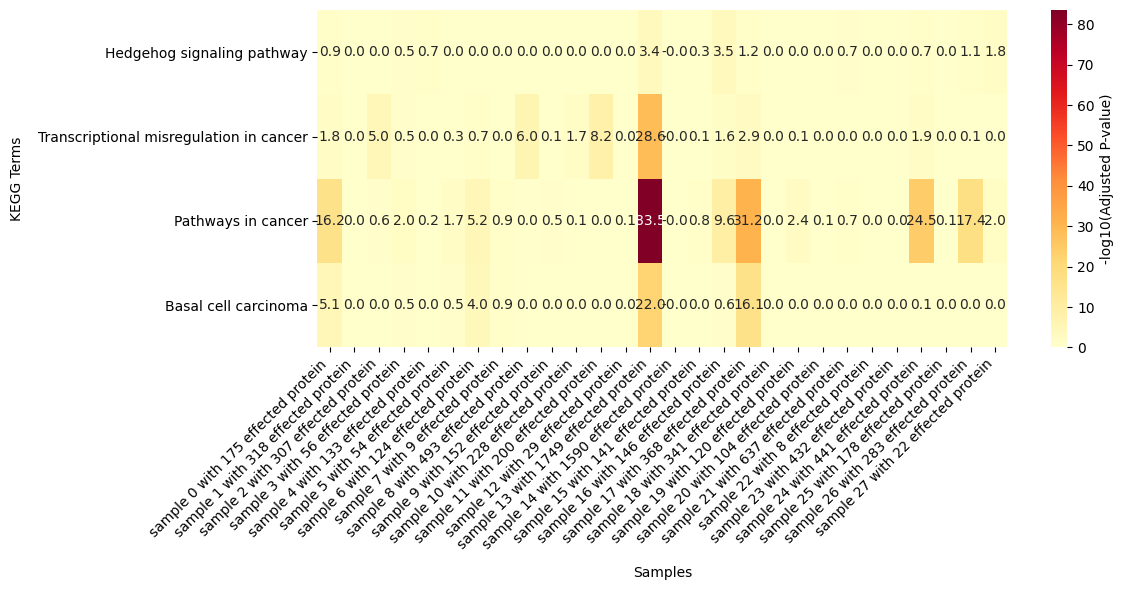

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"sample {i} with {str(number[i])} effected protein" for i in range(len(result[start:]))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()

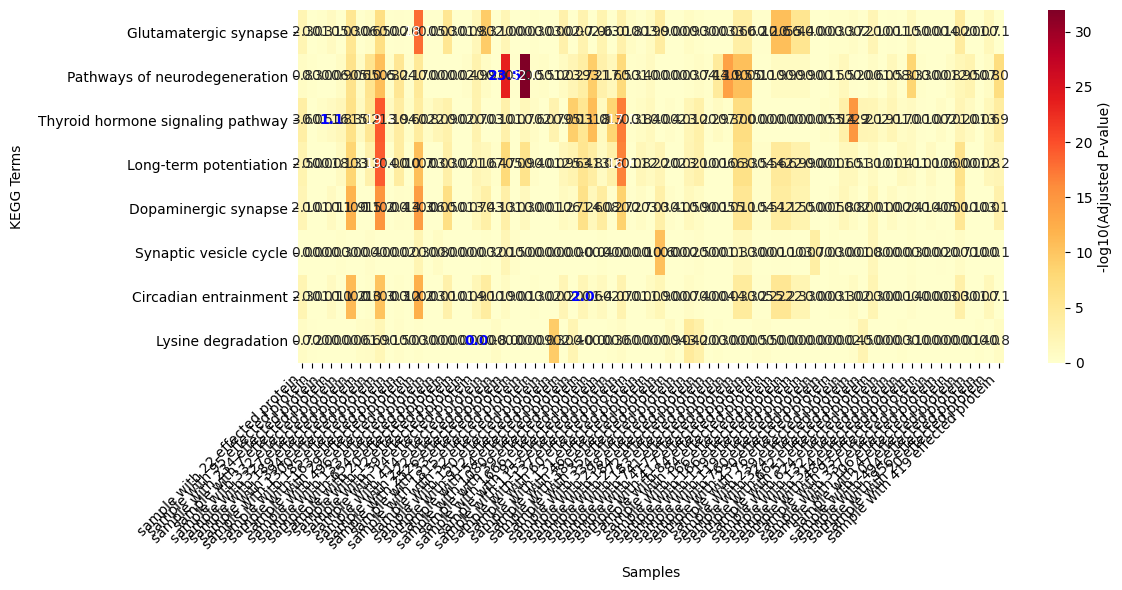

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"sample with {str(number[i])} effected protein" for i in range(len(result[start:]))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()

In [10]:
sample_index = 5
GO_index = 0
use = ASD_list[sample_index]
effected = use[0]+use[1]+use[3]
print(set(use[0])&set(gene_sets[important_GO[GO_index]]), set(use[1]) & set(gene_sets[important_GO[GO_index]]), set(use[3]) & set(gene_sets[important_GO[GO_index]]))
for iiia in set(effected) & set(gene_sets[important_GO[GO_index]]):
    print(iiia)
print(samples.iloc[sample_index]['Gene.refGene'])
set(effected) & set(gene_sets[important_GO[GO_index]]), samples.iloc[sample_index]['Gene.refGene'], important_GO[GO_index]


NameError: name 'ASD_list' is not defined

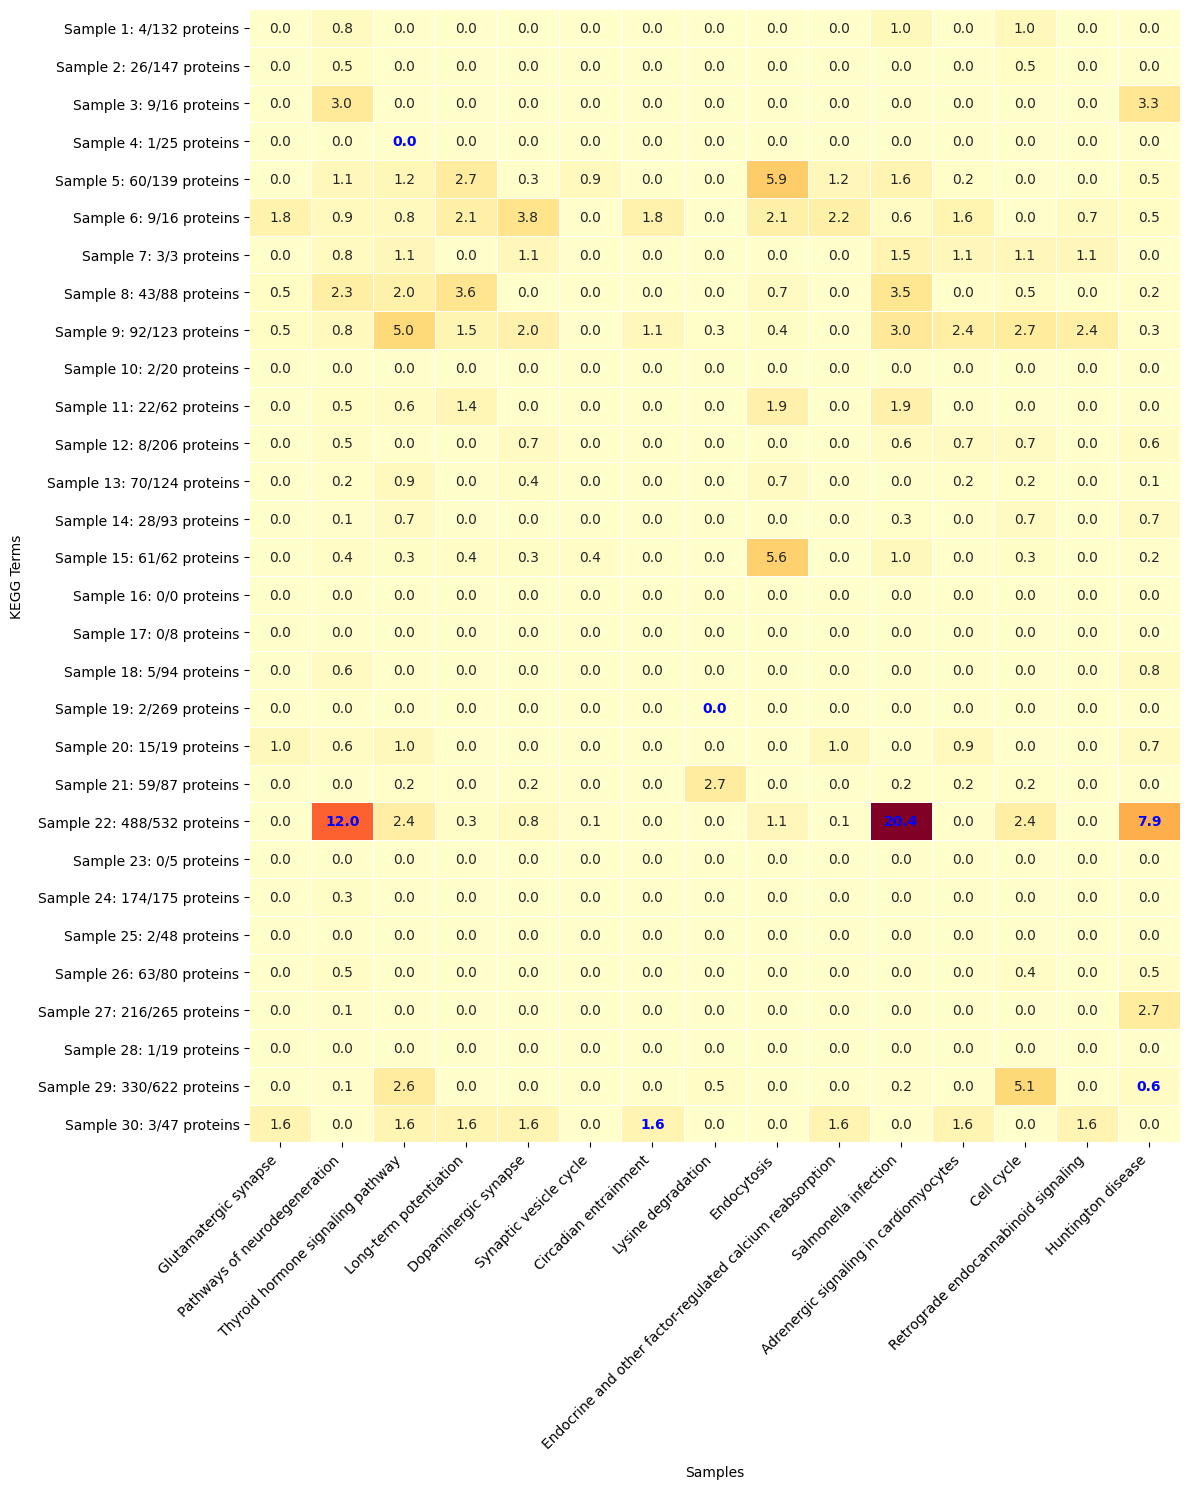

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data = np.array(result[start:])  # 转置数据（行=Terms，列=样本）

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar=False,
    yticklabels=[f"Sample {i+1}: {number[i]}/{number2[i]} proteins" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    cbar_kws={"label": "-log10(Adjusted P-value)"},
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('blue')
        text.set_weight('bold')
plt.savefig('../manything/ASD_hotplot.png', dpi=500, bbox_inches='tight')
# 自动调整布局
plt.tight_layout()
plt.show()

In [32]:
set(use[2]) & set(gene_sets[important_GO[GO_index]]), set(use[3]) & set(gene_sets[important_GO[GO_index]]), set(use[1]) & set(gene_sets[important_GO[GO_index]])

({'DYNLL1', 'IKBKG'},
 {'CASP3'},
 {'ACTR1A',
  'ACTR2',
  'ACTR3C',
  'ANXA2',
  'ARF1',
  'ARF6',
  'ARL8A',
  'ARL8B',
  'ARPC2',
  'BCL2',
  'CASP1',
  'CASP8',
  'CDC42',
  'CHUK',
  'CTNNB1',
  'CYCS',
  'DNM2',
  'DYNC1I1',
  'DYNC1I2',
  'DYNLL2',
  'DYNLRB1',
  'FADD',
  'FLNA',
  'FLNC',
  'FOS',
  'GAPDH',
  'HSP90AA1',
  'HSP90AB1',
  'HSP90B1',
  'IKBKB',
  'IL1B',
  'IL6',
  'KIF5A',
  'KPNA3',
  'KPNA4',
  'MAPK1',
  'MAPK14',
  'MAPK3',
  'MYL10',
  'MYL12A',
  'MYL12B',
  'MYL2',
  'MYL5',
  'MYL7',
  'MYL9',
  'MYLPF',
  'NFKB1',
  'NFKBIA',
  'PFN1',
  'PFN2',
  'PFN4',
  'RAB5A',
  'RAC1',
  'RAF1',
  'RALA',
  'RELA',
  'RHOA',
  'RHOB',
  'RHOG',
  'RHOH',
  'RILP',
  'RIPK3',
  'ROCK2',
  'RPS3',
  'TNF',
  'TUBA1B',
  'TUBA1C',
  'TUBA3C',
  'TUBA3D',
  'TUBA3E',
  'TUBA4A',
  'TUBA8',
  'TUBAL3',
  'TXN',
  'TXN2'})

In [33]:
set(use[0]) & set(gene_sets[important_GO[GO_index]])

{'ACTB',
 'ACTG1',
 'ACTR10',
 'ACTR1B',
 'ACTR3',
 'ACTR3B',
 'AHNAK',
 'AHNAK2',
 'AKT1',
 'AKT3',
 'ARPC1A',
 'ARPC1B',
 'ARPC4',
 'DCTN1',
 'DCTN2',
 'DYNC1H1',
 'DYNC1LI1',
 'DYNC1LI2',
 'DYNC2H1',
 'DYNLRB2',
 'DYNLT1',
 'DYNLT3',
 'FLNB',
 'GCC2',
 'HRAS',
 'IRAK1',
 'IRAK4',
 'JUN',
 'KIF5B',
 'KIF5C',
 'KLC1',
 'KLC2',
 'KLC3',
 'KLC4',
 'KPNA1',
 'MYC',
 'MYD88',
 'NOD1',
 'PFN3',
 'PKN1',
 'RAB7A',
 'RAB7B',
 'RHOJ',
 'RIPK1',
 'RIPK2',
 'RRAS',
 'S100A10',
 'TAB1',
 'TLR4',
 'TUBB',
 'TUBB1',
 'TUBB2A',
 'TUBB2B',
 'TUBB3',
 'TUBB4A',
 'TUBB4B',
 'TUBB6',
 'TUBB8'}

In [31]:
sample_index = 21
GO_index = 10
use = ASD_list[sample_index]
effected = use[0]+use[1]+use[3]
print(set(use[0])&set(gene_sets[important_GO[GO_index]]), set(use[1]) & set(gene_sets[important_GO[GO_index]]), set(use[3]) & set(gene_sets[important_GO[GO_index]]))
for iiia in set(effected) & set(gene_sets[important_GO[GO_index]]):
    print(iiia)
print(samples.iloc[sample_index]['Gene.refGene'])
# set(effected) & set(gene_sets[important_GO[GO_index]]), samples.iloc[sample_index]['Gene.refGene'], important_GO[GO_index]
important_GO[GO_index]

{'ACTR3B', 'KPNA1', 'ARPC1B', 'AKT3', 'RAB7B', 'GCC2', 'DYNLT1', 'KLC1', 'ARPC1A', 'S100A10', 'DYNLRB2', 'TUBB8', 'MYC', 'RIPK2', 'TUBB4A', 'KLC4', 'DYNC1H1', 'TUBB4B', 'TUBB3', 'TUBB2B', 'DYNLT3', 'ARPC4', 'TUBB', 'RAB7A', 'RRAS', 'PFN3', 'TUBB2A', 'ACTR1B', 'DYNC2H1', 'HRAS', 'TLR4', 'NOD1', 'AHNAK', 'RHOJ', 'IRAK4', 'KIF5C', 'DYNC1LI2', 'KLC3', 'DCTN2', 'ACTG1', 'PKN1', 'KIF5B', 'DCTN1', 'MYD88', 'TAB1', 'AHNAK2', 'FLNB', 'KLC2', 'ACTR10', 'ACTB', 'DYNC1LI1', 'RIPK1', 'AKT1', 'TUBB6', 'ACTR3', 'TUBB1', 'JUN', 'IRAK1'} {'HSP90B1', 'KPNA4', 'ANXA2', 'DYNLRB1', 'PFN4', 'RHOH', 'ARL8A', 'FLNA', 'TUBA1C', 'RAF1', 'RPS3', 'RHOA', 'MAPK3', 'FADD', 'NFKB1', 'ACTR1A', 'RILP', 'ARF1', 'HSP90AB1', 'RELA', 'IKBKB', 'MAPK14', 'MYL12B', 'MYL9', 'ACTR2', 'FOS', 'DYNC1I2', 'DYNLL2', 'PFN2', 'IL6', 'TUBA8', 'ROCK2', 'TUBAL3', 'TUBA1B', 'DYNC1I1', 'HSP90AA1', 'RALA', 'TUBA3D', 'NFKBIA', 'IL1B', 'BCL2', 'ARF6', 'MYL7', 'TNF', 'ARPC2', 'MYL12A', 'MYL5', 'CASP8', 'TXN2', 'CHUK', 'MAPK1', 'TXN', 'TUBA4A'

'Salmonella infection'

In [25]:
gene_sets[important_GO[GO_index]] # XMAP215

['DYNC2H1',
 'AHNAK2',
 'MAPK13',
 'MAPK14',
 'DYNC1LI1',
 'MAPK11',
 'MYL5',
 'DYNC1LI2',
 'MAPK12',
 'MYL7',
 'MAPK10',
 'MYL2',
 'BAX',
 'MYL9',
 'PFN2',
 'NAIP',
 'PFN1',
 'PFN4',
 'PFN3',
 'LEF1',
 'CYFIP2',
 'CYFIP1',
 'AHNAK',
 'RALA',
 'TUBAL3',
 'ARPC5L',
 'NOD1',
 'SNX33',
 'STX10',
 'MYL12B',
 'ACTB',
 'AKT3',
 'MYC',
 'AKT1',
 'MYL10',
 'AKT2',
 'VPS11',
 'RILP',
 'S100A10',
 'VPS16',
 'VPS18',
 'NCKAP1L',
 'MYL12A',
 'MYLPF',
 'TXN',
 'GCC2',
 'ACTR3B',
 'ACTR3C',
 'TNFSF10',
 'CD14',
 'SKP1',
 'GSDMD',
 'RHOA',
 'ANXA2',
 'JUN',
 'RIPK3',
 'TUBB',
 'RHOH',
 'IL18',
 'RHOG',
 'TUBB2A',
 'RHOB',
 'TLR2',
 'IL1B',
 'PTPRC',
 'TUBB2B',
 'RHOJ',
 'EXOC5',
 'PLEKHM2',
 'EXOC4',
 'TLR9',
 'EXOC7',
 'PLEKHM1',
 'ACTR10',
 'TLR6',
 'TLR5',
 'RAB7A',
 'TLR4',
 'EXOC2',
 'RAB7B',
 'ARPC1A',
 'RAB5C',
 'ARF1',
 'ARPC1B',
 'ACTR1A',
 'ACTR1B',
 'MYO6',
 'RRAS',
 'FADD',
 'RIPK2',
 'RIPK1',
 'SNX9',
 'DYNC1I2',
 'DYNC1I1',
 'DYNLL1',
 'FOS',
 'DYNLL2',
 'TUBB4B',
 'TUBB4A',
 'SNX18',
 

SIN3A Thyroid hormone signaling pathway 5
SIN3A Huntington disease 5


2025-04-28 02:41:10,932 [ERROR] No hits returned for all input gene sets!


11


2025-04-28 02:41:12,278 [ERROR] No hits returned for all input gene sets!


19
GABRP Retrograde endocannabinoid signaling 21
FGFR2 Endocytosis 25
MED13 Thyroid hormone signaling pathway 26


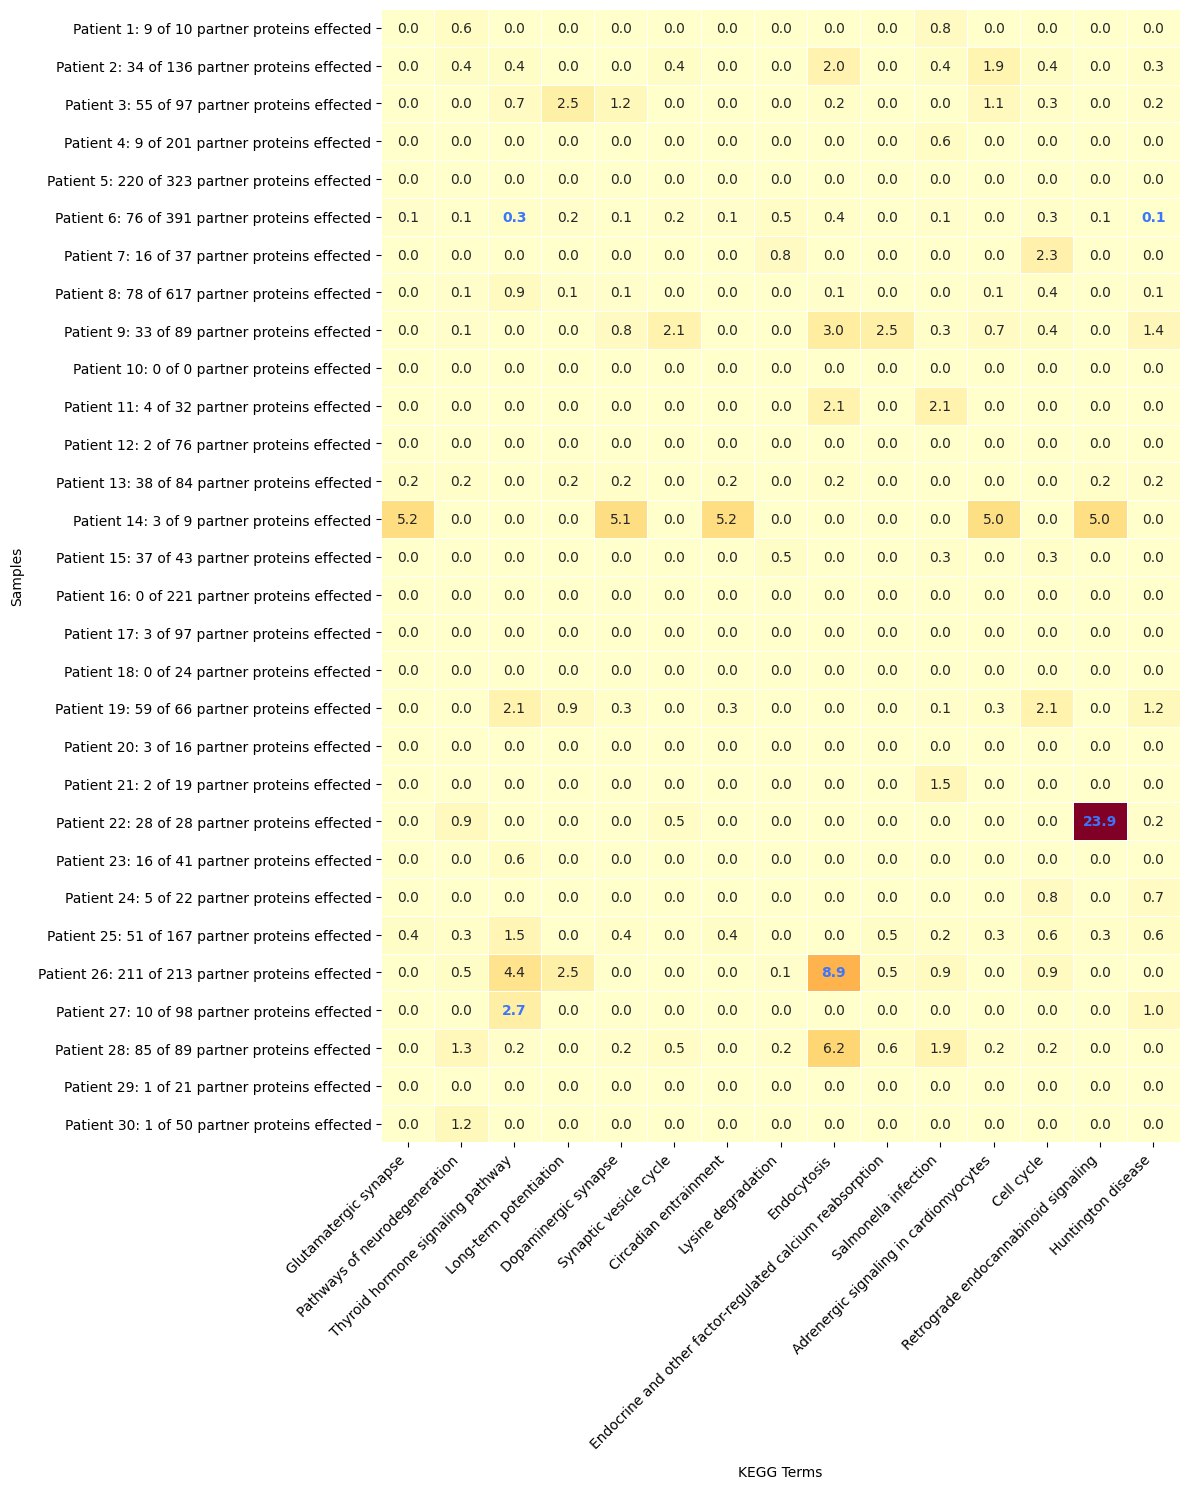

In [34]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
# samples = pd.read_csv('../manything/ASD_use.csv')
# samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
# samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []
numberb = []

ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []

nnnn = 30
import json
with open('../manything/disease_onlyp_Control2.json', 'r') as f:
    CDH_list = json.load(f)

# for index, sample in enumerate(CDH_list):
#     use_gene = list(G.neighbors(sample['mutation']))
#     # if any(item not in sample['nab'][0]+sample['nab'][1]+sample['nab'][2]+sample['nab'][3] for item in use_gene):
#     #     print('err0')
#     #     break

#     for class_index in range(len(sample['nab'])):
#         CDH_list[index]['nab'][class_index] = [gene for gene in CDH_list[index]['nab'][class_index] if gene in use_gene]

for idx, sample in enumerate(CDH_list):
    if len(buer) == nnnn + 1:
        break
    sample_result = []
    samplep = sample['nab']
    use_gene = samplep[0] + samplep[1] + samplep[3]# + [samples.iloc[idx]['Gene.refGene']]
    # print(len(use_gene))
    geneuse = sample['mutation']
    number.append(len(use_gene))
    numberb.append(len(samplep[0] + samplep[1] + samplep[2] + samplep[3]))
    if len(use_gene) == 0:
        result.append([0 for _ in range(len(important_GO))])

        sample_buer = []
        # print(len(use_gene))
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)
        
        continue
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    if len(pandas_use) == 0:
        print(idx)
        result.append([0 for _ in range(len(important_GO))])
        sample_buer = []
        for GO in important_GO:
            
            if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
                sample_buer.append(1)
                print(geneuse, GO, idx)
            else:
                sample_buer.append(0)  # 未找到，填充 0
        buer.append(sample_buer)



        
        continue
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            
            sample_result.append(-math.log10(p_value))

            # p_value = item['Overlap'].values[0]  # 提取 P-value
            
            # sample_result.append(int(p_value.split('/')[0]))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)


    sample_buer = []
    # print(len(use_gene))
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data2 = np.array(result[start:])  # 转置数据（行=Terms，列=样本）

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 绘制热图（使用黄到红的经典热图颜色）
ax = sns.heatmap(
    data2,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd',  # 使用黄到红的经典热图颜色
    cbar=False,
    yticklabels=[f"Patient {i+1}: {number[i]} of {numberb[i]} partner proteins effected" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
plt.xlabel("KEGG Terms", labelpad=10)
plt.ylabel("Samples", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('#3b76fb')
        text.set_weight('bold')

plt.savefig('../manything/Control_ASD_hotplot.png', dpi=500, bbox_inches='tight')
# 自动调整布局
plt.tight_layout()
plt.show()

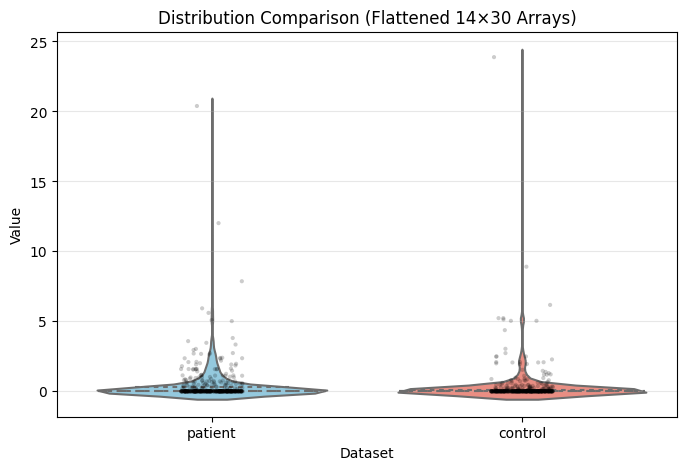

In [10]:
flat_data = data.flatten()    # 420个元素
flat_data2 = data2.flatten()  # 420个元素

# 合并为DataFrame
import pandas as pd
df = pd.DataFrame({
    'Value': np.concatenate([flat_data, flat_data2]),
    'Dataset': ['patient'] * len(flat_data) + ['control'] * len(flat_data2)
})

# 绘制对比小提琴图
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df,
    x='Dataset',
    y='Value',
    palette={'patient': 'skyblue', 'control': 'salmon'},
    inner='quartile',  # 显示四分位数线
    bw=0.2            # 控制平滑度
)

# 添加统计标记
sns.stripplot(
    data=df,
    x='Dataset',
    y='Value',
    color='black',
    alpha=0.2,
    jitter=True,
    size=3
)

plt.title('Distribution Comparison (Flattened 14×30 Arrays)')
plt.ylabel('Value')
plt.grid(axis='y', alpha=0.3)
plt.show()

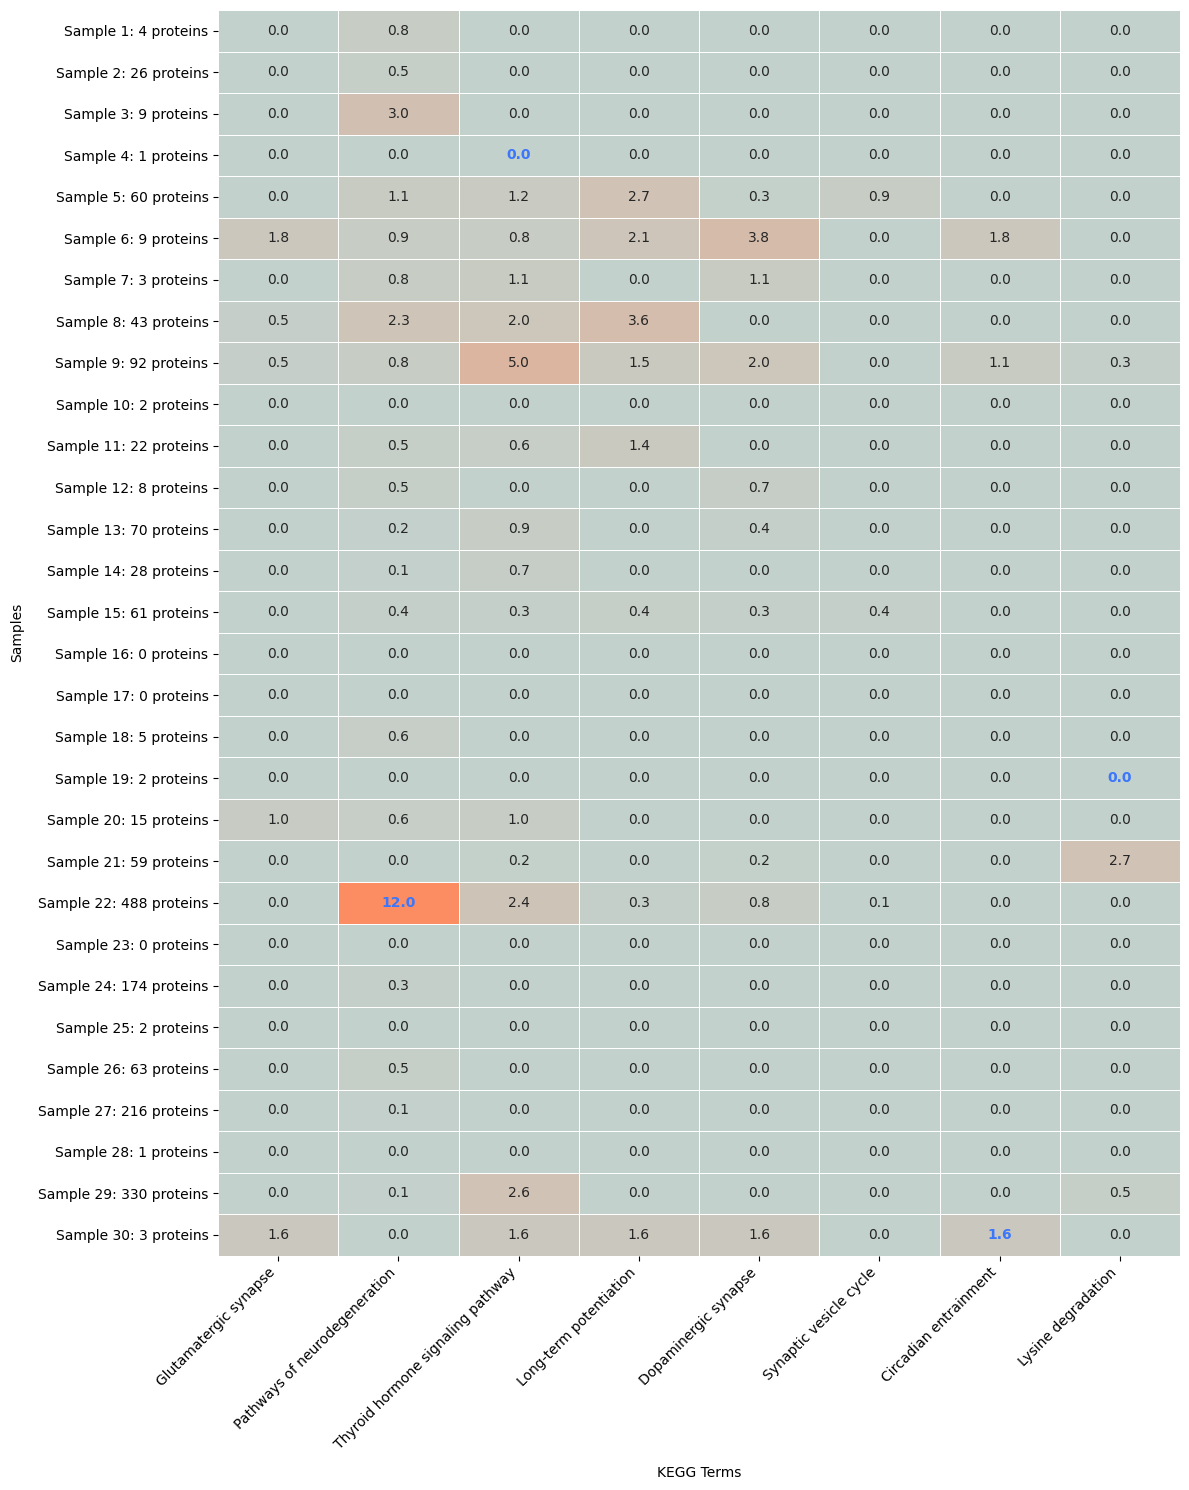

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data = np.array(result[start:])  # 转置数据（行=Terms，列=样本）

# --- 自定义色板 (白色 -> #fc8d62) ---
colors = ["#c3d1cc", "#fc8d62"]  # 从白色过渡到目标颜色
custom_cmap = LinearSegmentedColormap.from_list("custom_orange", colors)

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 绘制热图（使用自定义色板）
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap=custom_cmap,  # 使用自定义色板
    cbar=False,
    yticklabels=[f"Sample {i+1}: {number[i]} proteins" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
plt.xlabel("KEGG Terms", labelpad=10)
plt.ylabel("Samples", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('#3b76fb')
        text.set_weight('bold')
plt.savefig('../manything/ASD_hotplot.png', dpi=500, bbox_inches='tight')
# 自动调整布局
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data = np.array(result[start:])  # 转置数据（行=Terms，列=样本）

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 自定义颜色映射
cmap = sns.color_palette("YlOrRd", as_cmap=True)

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap=cmap,
    cbar=False,
    yticklabels=[f"Sample {i+1}: {number[i]} proteins" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[start:][col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('#66c2a5')  # 设置选中单元格的颜色为66c2a5
        text.set_weight('bold')

# 自动调整布局
plt.tight_layout()
plt.show()

ValueError: #YlOrRd is not a valid palette name

<Figure size 1200x1500 with 0 Axes>

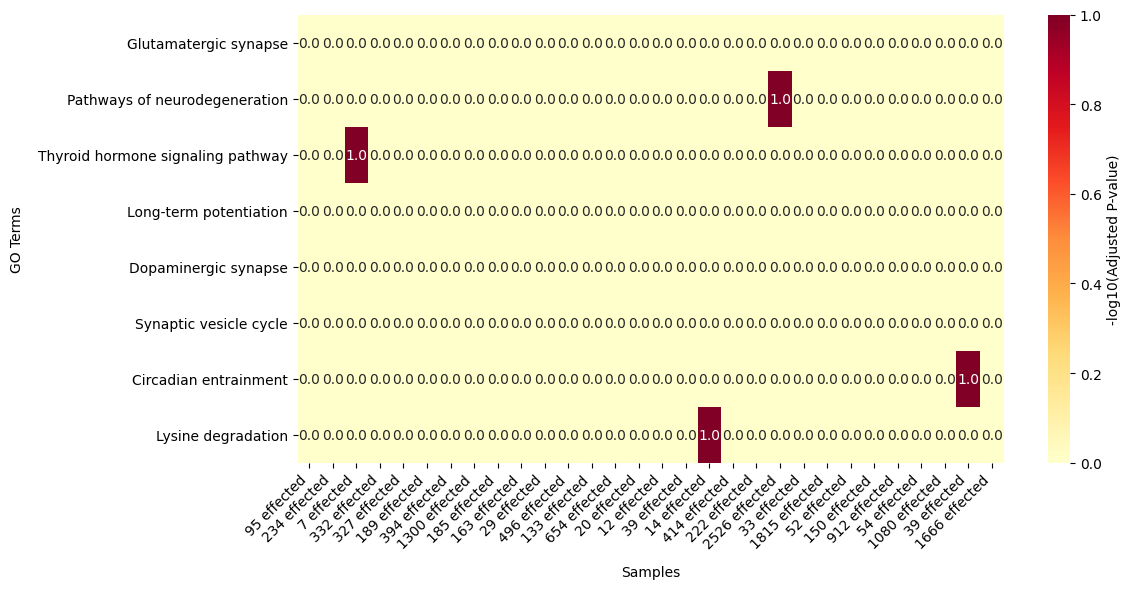

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
data = np.array(buer).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"{str(number[i])} effected" for i in range(len(result))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("GO Terms", labelpad=10)

# 确保标签不被截断
plt.tight_layout()

plt.show()

In [39]:
sample = ASD_list[0]
use_gene = sample[0] + sample[1] + sample[3]
# print(len(use_gene))
# number.append(len(use_gene))
enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
             gene_sets=gene_sets,
             organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None, # don't write to disk
            )
pandas_use = enr.results
ooo = 7
item = pandas_use[pandas_use['Term'] == important_GO[ooo]]
print(important_GO[ooo])
if not item.empty:  # 检查是否找到匹配项
    p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
    print(-math.log10(p_value))
else:
    print(0)  # 未找到，填充 0

Lysine degradation
0.2375864067943114


In [2]:
import networkx as nx

# 从 GML 文件读取图
G = nx.read_gml('../manything/graph_ppi.gml')

In [21]:
import pandas as pd
samples = pd.read_csv('../manything/ASD_use.csv')
samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
samples['PrimaryPhenotype'].value_counts(), samples.shape

/tmp/ipykernel_438679/222384378.py:2: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('../manything/ASD_use.csv')


(PrimaryPhenotype
 Autism (ASD)    4572
 Name: count, dtype: int64,
 (4572, 169))

In [31]:
def get_nerb(node_a, G):
    if node_a in G:
        connected_nodes = list(G.neighbors(node_a))
    else:
        connected_nodes = []
    return connected_nodes

In [36]:
# samples.iloc[1]['Gene.refGene']
i = 2
set(get_nerb(samples.iloc[i + 1]['Gene.refGene'], G)) == set(ASD_list[i][0] + ASD_list[i][1] + ASD_list[i][2] + ASD_list[i][3])

True

In [51]:
important_GO

['Glutamatergic synapse',
 'Pathways of neurodegeneration',
 'Thyroid hormone signaling pathway',
 'Long-term potentiation',
 'Dopaminergic synapse',
 'Synaptic vesicle cycle',
 'Circadian entrainment',
 'Lysine degradation']

In [3]:
import gseapy as gp
import math
gene_sets = {}
with open("../manything/CORUM.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis
ssss = {}
important_GO = []
for key in gene_sets.keys():
    ssss[key] = []
for use_gene in importants:
    sample_result = []
    # use_gene = sample[0] + sample[1] + sample[3]
    # print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    # if len(result) == 30:
    #     break
# Calculate the average for each GO term in ssss
average_scores = {go: (sum(scores) / len(scores) if scores else 0) for go, scores in ssss.items()}

# Find the top 5 GO terms with the highest average scores
top_5_go = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:8]

# Print the results
important_GO = []
for go_term, avg_score in top_5_go:
    print("GO term:", go_term, "Average score:", avg_score)
    important_GO.append(go_term)

NameError: name 'importants' is not defined

In [115]:
top_5_go = sorted(average_scores.items(), key=lambda item: item[1], reverse=True)[:15]

# Print the results
important_GO = []
for go_term, avg_score in top_5_go:
    print("GO term:", go_term, "Average score:", avg_score)
    important_GO.append(go_term)
important_GO

GO term: LARC complex (LCR-associated remodeling complex) (human) Average score: 2.383374632678962
GO term: SWI-SNF chromatin remodeling-related-BRCA1 complex (human) Average score: 2.225616808359315
GO term: BRM-SIN3A complex (human) Average score: 2.1867535633170743
GO term: BRG1-SIN3A complex (human) Average score: 2.1066607538259166
GO term: BAF complex (human) Average score: 2.088443123604986
GO term: SIN3-ING1b complex II (human) Average score: 2.024210070824761
GO term: WINAC complex (human) Average score: 2.0179832249183103
GO term: ALL-1 supercomplex (human) Average score: 1.9996129994307044
GO term: BRM-SIN3A-HDAC complex (human) Average score: 1.9131041546663483
GO term: NuA4/Tip60-HAT complex A (human) Average score: 1.8776526878680329
GO term: p300-CBP-p270-SWI/SNF complex (human) Average score: 1.8555636104434226
GO term: DMAP1-associated complex (human) Average score: 1.6705943875392932
GO term: RSmad complex (human) Average score: 1.6426144935898315
GO term: EBAFb compl

['LARC complex (LCR-associated remodeling complex) (human)',
 'SWI-SNF chromatin remodeling-related-BRCA1 complex (human)',
 'BRM-SIN3A complex (human)',
 'BRG1-SIN3A complex (human)',
 'BAF complex (human)',
 'SIN3-ING1b complex II (human)',
 'WINAC complex (human)',
 'ALL-1 supercomplex (human)',
 'BRM-SIN3A-HDAC complex (human)',
 'NuA4/Tip60-HAT complex A (human)',
 'p300-CBP-p270-SWI/SNF complex (human)',
 'DMAP1-associated complex (human)',
 'RSmad complex (human)',
 'EBAFb complex (human)',
 'NCOR1 complex (human)']

In [116]:
import json
nnnn = 30
with open('../manything/pathway_analyse.json', 'r') as f:
    ASD_list = json.load(f)
result = []
for sample in ASD_list:
    sample_result = []
    use_gene = sample[0] + sample[1] + sample[3]
    print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    if len(result) == nnnn:
        break
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []
for idx, sample in enumerate(ASD_list):
    sample_buer = []
    # print(len(use_gene))
    pandas_use = enr.results
    geneuse = samples.iloc[idx]['Gene.refGene']
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

95
234
7
332
327
189
394
1300
185
163
29
496
133
654
20
12
39
14
414
222
2526
33
1815
52
150
912
54
1080
39
1666


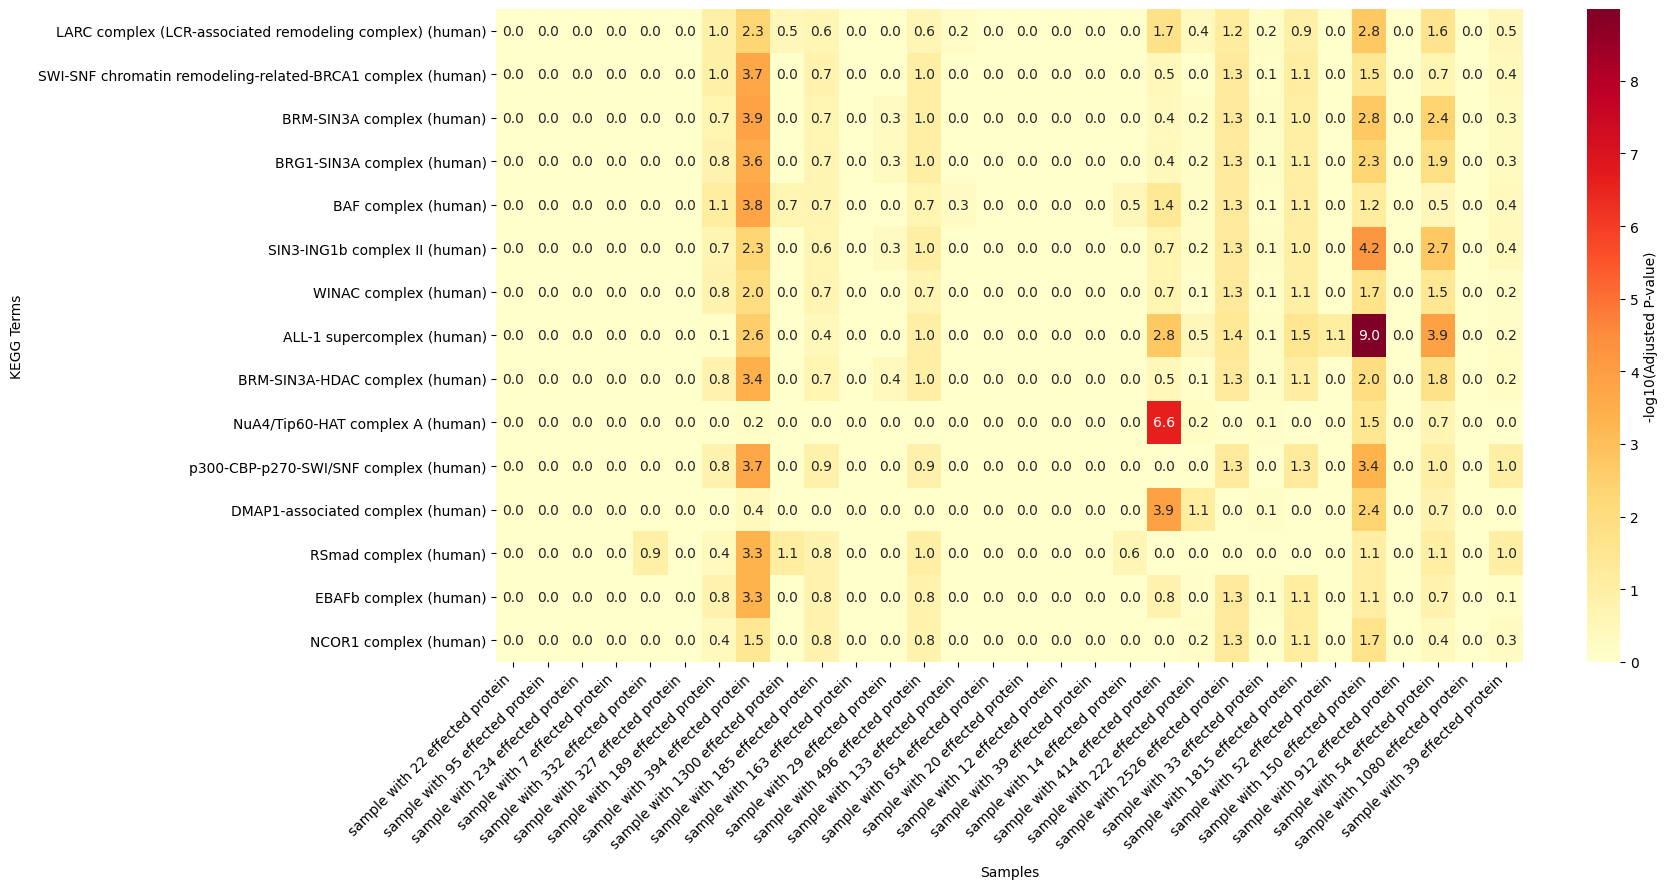

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(18, 9))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"sample with {str(number[i])} effected protein" for i in range(len(result[start:]))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()

IndexError: list index out of range

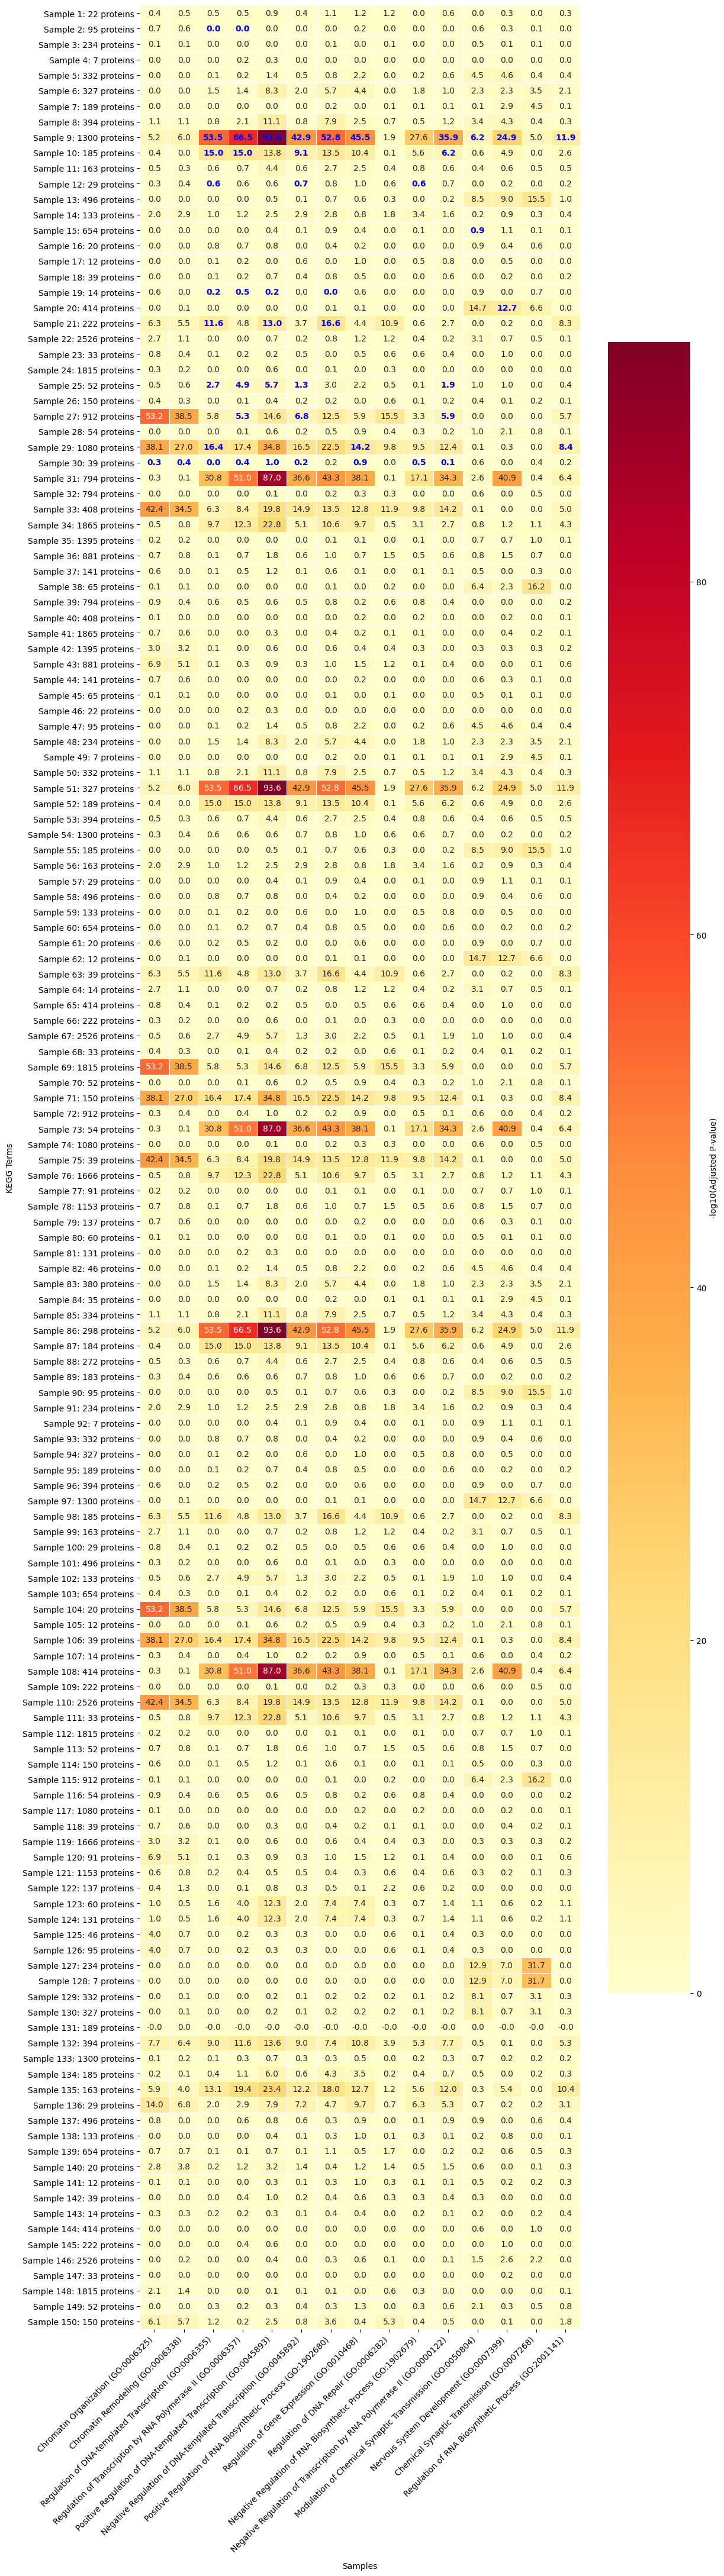

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 result 是原始数据（行=样本，列=GO/KEGG Terms）
start = 0
data = np.array(result)  # 转置数据（行=Terms，列=样本）

# --- 自适应高度计算 ---
# 基础高度（每个Term分配0.3英寸，最小6英寸）
base_height = 6  
term_height = 0.3  # 每个Term的高度（英寸）
dynamic_height = base_height + term_height * data.shape[0]  # 根据行数调整

# 创建画布（宽度固定，高度动态）
plt.figure(figsize=(12, dynamic_height))

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    yticklabels=[f"Sample {i+1}: {number[i]} proteins" for i in range(len(result[start:]))],
    xticklabels=important_GO[start:],  # 直接使用GO/KEGG名称列表
    cbar_kws={"label": "-log10(Adjusted P-value)"},
    linewidths=0.5  # 添加细线分隔单元格
)

# 调整标签样式
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    ax.get_yticklabels(), 
    fontsize=10,
    rotation=0  # 保证纵轴标签水平显示
)

# 设置轴标签
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

# 高亮特定单元格（根据buer矩阵）
for text in ax.texts:
    row, col = map(int, text.get_position())
    if buer[col][row] == 1:  # 注意转置后行列索引变化
        text.set_color('blue')
        text.set_weight('bold')

# 自动调整布局
plt.tight_layout()
plt.show()

In [12]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
samples = pd.read_csv('../manything/ASD_use.csv')
samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/CORUM.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

for sample_index in range(len(ASD_list)):
    sample = ASD_list[sample_index]
    effected = sample[0] + sample[1] + sample[3]
    gene_with_mutation = {}
    for pathway in gene_sets.keys():
        if samples.iloc[sample_index]['Gene.refGene'] in gene_sets[pathway]:
            gene_with_mutation[pathway] = gene_sets[pathway]
    if len(gene_with_mutation) != 0 :
        print(samples.iloc[sample_index]['Gene.refGene'], sample_index)


/tmp/ipykernel_2983813/1051916321.py:5: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('../manything/ASD_use.csv')


DAG1 4
MPDZ 12
TUBA1A 21
POLR2A 28
TOP1 32
ELK1 33
AP3B2 38
INPP5K 56
ITK 57
MOV10 59


In [13]:
import gseapy as gp
import math
import json
gene_sets = {}
import pandas as pd
from gseapy import barplot, dotplot
with open('../manything/pathway_analyse1.json', 'r') as f:
    ASD_list = json.load(f)
samples = pd.read_csv('../manything/ASD_use.csv')
samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/CORUM.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes
#21的三个蛋白复合物两个与神经退行疾病相关
sample_index = 28
sample = ASD_list[sample_index]
effected = sample[0] + sample[1] + sample[3]
gene_with_mutation = {}
for pathway in gene_sets.keys():
    if samples.iloc[sample_index]['Gene.refGene'] in gene_sets[pathway]:
        gene_with_mutation[pathway] = gene_sets[pathway]
len(gene_with_mutation)
enr = gp.enrichr(gene_list=effected, # or "./tests/data/gene_list.txt",
             gene_sets=gene_with_mutation,
             organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None, # don't write to disk
            )
enr.results.head()

/tmp/ipykernel_276271/2349228147.py:9: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('../manything/ASD_use.csv')


Gene_set                                               Term Overlap  \
0  gs_ind_0  Actin-ribonucleoprotein complex (POLR2A, GTF2F...     2/3   
1  gs_ind_0                 BRCA1-BARD1-POLR2A complex (human)     2/3   
2  gs_ind_0            BRCA1-RNA polymerase II complex (human)   14/26   
3  gs_ind_0       BRCA1-core RNA polymerase II complex (human)    6/13   
4  gs_ind_0                         CSA-POLIIa complex (human)    7/14   

    P-value  Adjusted P-value  Odds Ratio  Combined Score  \
0  0.523932          0.949685    1.596491        1.031962   
1  0.523932          0.949685    1.596491        1.031962   
2  0.484046          0.949685    1.127324        0.817958   
3  0.763937          0.949685    0.786973        0.211908   
4  0.661929          0.949685    0.929412        0.383473   

                                               Genes  
0                                      GTF2F1;HNRNPU  
1                                        BRCA1;BARD1  
2  GTF2H1;TBP;POLR2B;POLR2I;GTF2E2;BRCA1;POLR2L;G...  
3           POLR2B;POLR2I;BRCA1;POLR2L;POLR2E;POLR2K  
4           COPS5;RBX1;COPS4;COPS7A;DDB1;COPS6;CUL4A

In [14]:
enr.results['Term'].tolist()

['Actin-ribonucleoprotein complex (POLR2A, GTF2F1, HNRNPU) (human)',
 'BRCA1-BARD1-POLR2A complex (human)',
 'BRCA1-RNA polymerase II complex (human)',
 'BRCA1-core RNA polymerase II complex (human)',
 'CSA-POLIIa complex (human)',
 'HES1 promoter corepressor complex (human)',
 'HES1 promoter-Notch enhancer complex (human)',
 'Integrator-RNAPII complex (human)',
 'POLR2A-CCNT1-CDK9-NCL-LEM6-CPSF2 complex (human)',
 'Pre-initiation complex (PIC) (human)',
 'RNA pol II containing coactivator complex Tat-SF (human)',
 'RNA polymerase II (RNAPII) (human)',
 'RNA polymerase II complex, chromatin structure modifying (human)',
 'RNA polymerase II core complex (human)',
 'RNA polymerase II holoenzyme complex (human)',
 'SMN-PolII-RHA complex (human)']

In [9]:
GOOO = 'RICH1/AMOT polarity complex, Flag-Amot precipitated (human)'
for nnna in gene_sets[GOOO]:
    print(nnna)

MPP5
AMOTL1
INADL
AMOTL2
ARHGAP17
MPDZ
MPP7
AMOT


In [17]:
import gseapy as gp
import math
gene_sets = {}
import pandas as pd
# samples = pd.read_csv('../manything/ASD_use.csv')
# samples = samples[samples['PrimaryPhenotype'] == 'Autism (ASD)']
# samples['PrimaryPhenotype'].value_counts(), samples.shape
with open("../manything/KEGG_2021_Human.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        pathway = parts[0]
        genes = [g for g in parts[2:] if g]  # Skip empty strings
        gene_sets[pathway] = genes

# Perform enrichment analysis

# important_GO = [
#     "Amino acid metabolism",
#     "Neuroactive ligand-receptor interaction",
#     "Cytokine-cytokine receptor interaction",
#     "Calcium signaling pathway",
#     "Synaptic vesicle cycle"
# ]
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
result = []
number = []

nnnn = 30
import json
with open('../manything/disease_newPPI.json', 'r') as f:
    ASD_list = json.load(f)
for idx, sample_dict in enumerate(ASD_list):
    sample_result = []
    sample = sample_dict['nab']
    use_gene = sample[0] + sample[1] + sample[3]# + [samples.iloc[idx]['Gene.refGene']]
    if len(use_gene) == 0:
        result.append([0 for _ in range(len(important_GO))])
        number.append(len(use_gene))
        continue
    # print(len(use_gene))
    number.append(len(use_gene))
    enr = gp.enrichr(gene_list=use_gene, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    pandas_use = enr.results
    for GO in important_GO:
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            sample_result.append(-math.log10(p_value))
        else:
            sample_result.append(0)  # 未找到，填充 0
    for GO in gene_sets.keys():
        item = pandas_use[pandas_use['Term'] == GO]
        if not item.empty:  # 检查是否找到匹配项
            p_value = item['Adjusted P-value'].values[0]  # 提取 P-value
            ssss[GO].append(-math.log10(p_value))
        else:
            ssss[GO].append(0)  # 未找到，填充 0
    
    # result.append(normalize_to_zero_one(sample_result))
    result.append(sample_result)
    if len(result) == nnnn:
        break
ssss = {}
for key in gene_sets.keys():
    ssss[key] = []
buer = []
for idx, sample in enumerate(ASD_list):
    sample_buer = []
    # print(len(use_gene))
    pandas_use = enr.results
    geneuse = sample['mutation']
    for GO in important_GO:
        
        if geneuse in gene_sets[GO]:  # 检查是否找到匹配项
            sample_buer.append(1)
            print(geneuse, GO, idx)
        else:
            sample_buer.append(0)  # 未找到，填充 0
    buer.append(sample_buer)
    if len(buer) == nnnn:
        break

KMT2A Lysine degradation 12
TUBA1A Pathways of neurodegeneration 14
PER1 Circadian entrainment 20


In [16]:
len(number), len(result[start:])

(23, 30)

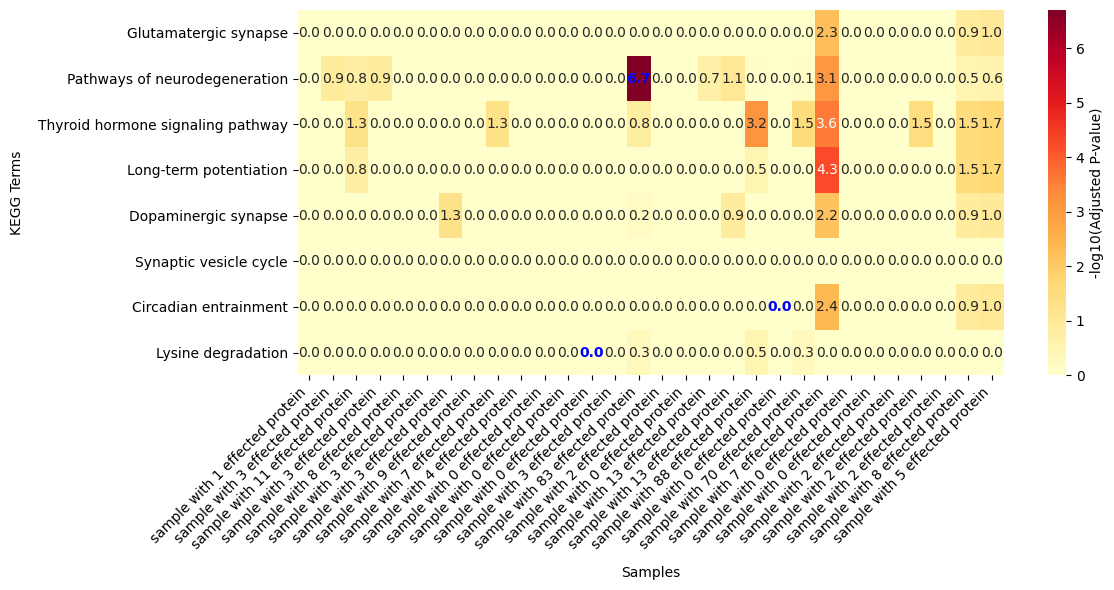

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 转换为 numpy 数组
start = 0
data = np.array(result[start:]).T  # 或 data = np.transpose(result)

# 绘制热图
plt.figure(figsize=(12, 6))  # 适当增加高度以适应旋转的标签

# 绘制热图
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    xticklabels=[f"sample with {str(number[i])} effected protein" for i in range(len(result[start:]))],
    yticklabels=[f"{j}" for j in important_GO],
    cbar_kws={"label": "-log10(Adjusted P-value)"}  # 修改颜色条标签
)

# 旋转横轴标签45度，并右对齐
ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=45, 
                  ha='right',
                  fontsize=10)

# 调整纵轴标签字体
ax.set_yticklabels(ax.get_yticklabels(), 
                  fontsize=10)

# 添加标题和轴标签
# plt.title("Transposed Heatmap (8x12)", pad=20)
plt.xlabel("Samples", labelpad=10)
plt.ylabel("KEGG Terms", labelpad=10)

for text in ax.texts:
    # 获取当前文本的位置（行和列）
    row, col = text.get_position()
    # if int(row) == 2 and int(col) == 3:  # 第3行第4列（索引从0开始）
    if buer[start:][int(row)][int(col)] == 1:
        text.set_color('blue')  # 修改颜色
        text.set_weight('bold')  # 可选：加粗
# 确保标签不被截断
plt.tight_layout()

plt.show()